# Halo 5 Match Prediction Model

Having spent many hours playing the specific Super Fiesta Party playlist, it seemed clear to me that we were being pit against players with a wide range of skill.  Sometimes, we would be beaten so badly that we couldn't help but laugh, despite having played just fine for the past few games.  

I wanted to know for certain whether or not games were, in a sense, predetermined in any given direction.  Of course this would never be the intention of a multiplayer matchmaking system.  In theory, a perfect match making system would always be a 50/50 matchup.  Using what we learned in the first section about data from the API, let's see how close to 50/50 matchmaking really is.

# Imports

We'll start by importing the same packages as our EDA notebook a long with an extensive set of sci-kit learn tools.

In [77]:
#Standard Packages
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pickle
import warnings
warnings.filterwarnings(action='ignore') 

# Packages used for API calls and data processing
import requests
import json
def get_keys(path):
    with open(path) as f:
        return json.load(f)
import ast
import time
import http.client, urllib.request, urllib.parse, urllib.error, base64
api_key = 'ceeaacb7cf024c7485e00ef8457e42dc'
gamertag = 'Drymander'
from tqdm import tqdm
# !pip install isodate
import isodate

In [78]:
# Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
scaler = StandardScaler()
from sklearn import metrics

# Models & Utilities
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder


# Intro

When I first started this project, I tried running models using matches from my personal history.  However, there was one major issue wwith that choice.  In order to get the features for our model, we will need to pull information that is only available from the API in a 'total lifetime' format.  

This means that if I played with a player **10 months ago**, I would actually only be able to pull features for that player for their stats **today**.  In other words, only the past ~3 weeks or so of matches could be considered passable as quality data where every player's time line synced with when the match was played.

Not satisfied with a model with poor quality and very scattered cross variance scores, I decided to go about it in a different way.

From my earlier data collection, I was able to amass a list of unique gamertag names that I have played with throughout time.  We will build a process to pull each of those players' 25 most recent games, put each game into one line of the dataframe, and limit the date range of those matches so that all data will be properly synced.

# Functions

To pull this off, we'll need to chain together some functions.

## Gamertag for API

This is a simple function to prepare anyone's gamertag from how it would normally appear to how it needs to be formatted for the API.

In [79]:
# Prepare gamertag for API
def gamertag_for_api(gamertag):
    
    # Replace spaces with '+'
    gamertag = gamertag.replace(' ','+')
    return gamertag

# Testing the function
gamertag_for_api('this is a test')

'this+is+a+test'

## Pull Recent Match

This pulls the most recent match information for any given player.

It uses two API calls.  The first will give us the match ID and date of the most recent game any player has played by specifying their gamertag.  The second calls the match results API, which gives us the gamertags of all players in the match as well as information on winner / loser / tie etc.  It will also give us Spartan Rank and Total XP.

In [80]:
# Function to pull most recent match stats into JSON format
# Uses two separate API calls, one from player history and another from match details
def pull_recent_match(how_recent, api_key=api_key, explore=False, gamertag='Drymander'):
    
    # Use gamertag_for_api function to remove any spaces
    gamertag = gamertag_for_api(gamertag)
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': api_key,
    }
    # Pulls from arena mode, how_recent is how far to go back in the match history
    # 'count' refers to the number of matches to pull
    params = urllib.parse.urlencode({
        # Request parameters
        'modes': 'arena',
        'start': how_recent,
        'count': 1,
        'include-times': True,
    })
    
    # Try this, otherwise return error message
    try:
        
        # Connect to API and pull most recent match for specified gamer
        conn = http.client.HTTPSConnection('www.haloapi.com')
        conn.request("GET", f"/stats/h5/players/{gamertag}/matches?%s" % params, "{body}", headers)
        response = conn.getresponse()
        latest_match = json.loads(response.read())
        
        # Identify match ID and match date
        match_id = latest_match['Results'][0]['Id']['MatchId']
        match_date = latest_match['Results'][0]['MatchCompletedDate']['ISO8601Date']
        
        # Rest for 1.01 seconds to not get blocked by API
        time.sleep(1.01)
        
        # Using match_id, pull details from match
        conn.request("GET", f"/stats/h5/arena/matches/{match_id}?%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = response.read()
        
        # Option to return as byte string for alternative viewing
        if explore == True:
            print(data)
        else:
            # Append match ID and date from player history API call
            match_results = json.loads(data)
            match_results['MatchId'] = match_id
            match_results['Date'] = match_date
        conn.close()
    
    # Print error if issue with calling API
    except Exception as e:
        print(f"[Errno {0}] {1}".format(e.errno, e.strerror))
    
    # Return match results as JSON
    return match_results

# Show result
match_results = pull_recent_match(0, explore=False, gamertag='Drymander')
match_results

{'PlayerStats': [{'XpInfo': {'PrevSpartanRank': 144,
    'SpartanRank': 144,
    'PrevTotalXP': 7112419,
    'TotalXP': 7114085,
    'SpartanRankMatchXPScalar': 2.244,
    'PlayerTimePerformanceXPAward': 543,
    'PerformanceXP': 99,
    'PlayerRankXPAward': 100,
    'BoostAmount': 0,
    'MatchSpeedWinAmount': 0,
    'ObjectivesCompletedAmount': 0},
   'PreviousCsr': None,
   'CurrentCsr': None,
   'MeasurementMatchesLeft': 10,
   'RewardSets': [{'RewardSet': 'ec0042e4-e06b-4c7b-8c03-d05000dbbd36',
     'RewardSourceType': 2,
     'SpartanRankSource': None,
     'CommendationLevelId': '8ebe5547-02e9-4521-992a-b61ebcef5489',
     'CommendationSource': 'be522e1e-eada-4ec7-aba9-7ee0c0d6732a'}],
   'KilledOpponentDetails': [{'GamerTag': 'Drymander', 'TotalKills': 2},
    {'GamerTag': 'MarySueMack', 'TotalKills': 4},
    {'GamerTag': 'Spartan1769691', 'TotalKills': 2},
    {'GamerTag': 'TheAceFace14', 'TotalKills': 4}],
   'KilledByOpponentDetails': [{'GamerTag': 'TheAceFace14', 'TotalKill

## Build Base Dataframe

Now that we have our match results JSON for the most recent match, we'll build a base dataframe similar to what we built in the EDA.

In [81]:
# Function to build the base dataframe for a single match
# Designed to take in the JSON provided by the pull_recent_match function
def build_base_dataframe(match_results, gamertag):
    
    # Build empty base match dataframe
    df = pd.DataFrame()
    columns = [
        'Finished'
        'TeamId',
        'Gamertag',
        'SpartanRank',
        'PrevTotalXP',
    ]
    df = pd.DataFrame(columns = columns)
    
    # Populate base match dataframe with player stats for each player
    i = 0
    for player in match_results['PlayerStats']:

        player_dic = {}
        # Team ID
        player_dic['DNF'] = match_results['PlayerStats'][i]['DNF']
        player_dic['TeamId'] = match_results['PlayerStats'][i]['TeamId']
        # Team Color
        player_dic['TeamColor'] = match_results['PlayerStats'][i]['TeamId']
        # Gamer Tag
        player_dic['Gamertag'] = match_results['PlayerStats'][i]['Player']['Gamertag']
        # Spartan Rank
        player_dic['SpartanRank'] = match_results['PlayerStats'][i]['XpInfo']['SpartanRank']
        # Previous Total XP
        player_dic['PrevTotalXP'] = match_results['PlayerStats'][i]['XpInfo']['PrevTotalXP']
        df = df.append(player_dic, ignore_index=True)
        i += 1
    
    ########## DATE, GAME VARIANT, MAP ID, MATCH ID, PLAYLIST ID ##########
    df['Date'] = match_results['Date']
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_convert(None)
#     df['Date'] = df['Date'].floor('T')
    df['MatchId'] = match_results['MatchId']
    df['GameBaseVariantId'] = match_results['GameBaseVariantId']
    df['MapVariantId'] = match_results['MapVariantId']
    df['PlaylistId'] = match_results['PlaylistId']
    
    ########## DEFINE PLAYER TEAM ##########
    playerteam = df.loc[df['Gamertag'] == gamertag, 'TeamId'].values[0]
    if playerteam == 0:
        enemyteam = 1   
    else:
        enemyteam = 0
        
    df['PlayerTeam'] = df['TeamId'].map({playerteam:'Player', enemyteam:'Enemy'})
    
    if match_results['TeamStats'][0]['TeamId'] == playerteam:
        playerteam_stats = match_results['TeamStats'][0]
        enemyteam_stats = match_results['TeamStats'][1]
    else: 
        playerteam_stats = match_results['TeamStats'][1]
        enemyteam_stats = match_results['TeamStats'][0]
    
    ########## DETERMINE WINNER ##########
    # Tie
    if playerteam_stats['Rank'] == 1 and enemyteam_stats['Rank'] == 1:
        df['Winner'] = 'Tie'
    # Player wins
    elif playerteam_stats['Rank'] == 1 and enemyteam_stats['Rank'] == 2:
        df['Winner'] = df['TeamId'].map({playerteam:'Victory', enemyteam:'Defeat'})
    # Enemy wins
    elif playerteam_stats['Rank'] == 2 and enemyteam_stats['Rank'] == 1:
        df['Winner'] = df['TeamId'].map({enemyteam:'Victory', playerteam:'Defeat'})
    # Error handling
    else:
        winner = 'Error determining winner'
    
    ########## TEAM COLOR ##########
    df['TeamColor'] = df['TeamId'].map({0:'Red', 1:'Blue'})
    
    # Set columns
    df = df[['Date', 'MatchId', 'GameBaseVariantId', 'PlaylistId', 'MapVariantId', 'DNF',
             'TeamId', 'PlayerTeam', 'Winner', 'TeamColor', 
             'Gamertag', 'SpartanRank', 'PrevTotalXP',
            ]]
    # Sort match by winning team
    df = df.sort_values(by=['Winner'], ascending=False)
    
    return df

df = build_base_dataframe(pull_recent_match(8), 'Drymander')

df.head()

,Date,MatchId,GameBaseVariantId,PlaylistId,MapVariantId,DNF,TeamId,PlayerTeam,Winner,TeamColor,Gamertag,SpartanRank,PrevTotalXP
0,2021-07-26 02:55:24.592,101ba1d1-1cac-444c-98c6-f6d871ad93da,a2949322-dc84-45ab-8454-cf94fb28c189,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,353f70fa-bd08-41cd-9d39-87e3e3967908,0.0,0.0,Player,Victory,Red,Asandovalpi,148,14124724
2,2021-07-26 02:55:24.592,101ba1d1-1cac-444c-98c6-f6d871ad93da,a2949322-dc84-45ab-8454-cf94fb28c189,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,353f70fa-bd08-41cd-9d39-87e3e3967908,0.0,0.0,Player,Victory,Red,WarriorAzteka81,150,28901357
3,2021-07-26 02:55:24.592,101ba1d1-1cac-444c-98c6-f6d871ad93da,a2949322-dc84-45ab-8454-cf94fb28c189,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,353f70fa-bd08-41cd-9d39-87e3e3967908,0.0,0.0,Player,Victory,Red,GYPSY DANGER619,149,20104631
4,2021-07-26 02:55:24.592,101ba1d1-1cac-444c-98c6-f6d871ad93da,a2949322-dc84-45ab-8454-cf94fb28c189,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,353f70fa-bd08-41cd-9d39-87e3e3967908,0.0,0.0,Player,Victory,Red,Drymander,148,15602141
1,2021-07-26 02:55:24.592,101ba1d1-1cac-444c-98c6-f6d871ad93da,a2949322-dc84-45ab-8454-cf94fb28c189,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,353f70fa-bd08-41cd-9d39-87e3e3967908,0.0,1.0,Enemy,Defeat,Blue,Dr DTF24,44,648510


## Get Player List

Now that we have our base dataframe, we'll want to use the gamertags in the match to get more extensive player information.  First, we'll need to prepare their gamertags for the API, similar to how we did it for our first function.

In [82]:
# Function to combine all gamertags from the match and prepare them in string
# format for the next API call
def get_player_list(df):
    
    # Create list from our df['Gamertag'] column and remove the brackets
    player_list = str(list(df['Gamertag']))[1:-1]
    
    # Format string for API
    player_list = player_list.replace(', ',',')
    player_list = player_list.replace("'",'')
    player_list = player_list.replace(' ','+')
    
    # Return in one full string
    return player_list

get_player_list(df)

'Asandovalpi,WarriorAzteka81,GYPSY+DANGER619,Drymander,Dr+DTF24,LuckyTurtle7595,sinz7257,SablePlacebo978'

## Get Player History

With the gamertags prepared in one string, we'll call the Player Service Records - Arena API, which will return a single JSON file for each player detailing their aggregate stats for every variety of Arena game type (Slayer, Capture the Flag, Oddball, Strongholds, etc).  This will have informatino like total wins, total losses, total kills / assists / deaths all specific to each game type.

While we'll never know for certain, the theory behind compiling the model dataframe by game type is that the features would be more representative of skill and experience in that game type.

To further elaborate, we'll be using games exclusively played in Super Fiesta Party playlist, which respawns players with randomized weapons after every death.  Even if a player is very skilled at Halo, if they have never played this variety of gametype before, they will not likely fare as well as they do in more traditional Halo game types (at least for their first few games).  Thus, total stats for a player's extended Halo history would not be representative of their skill in the Super Fiesta Party playlist.

We'll compile each player's service info in a list.

In [83]:
# Function to pull more informative information about each player in the match
# This information is not available in the two previous API calls
def get_player_history(df, readable=False):
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': str(api_key),
    }
    params = urllib.parse.urlencode({
    })
    # Use our function in the block above the prepare the gamertags for the API
    player_list_api = get_player_list(df)
    
    # Try calling service records API using our player list
    try:
        conn = http.client.HTTPSConnection('www.haloapi.com')
        conn.request("GET", f"/stats/h5/servicerecords/arena?players={player_list_api}&%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = response.read()
        player_history = json.loads(data)
        conn.close()
    
    # Return error if issue with API
    except Exception as e:
        print(f"[Errno {0}] {1}".format(e.errno, e.strerror))
    
    # Option to view in byte string readable format
    if readable == False:
        return player_history
    else:
        return data

# Show result
player_history = get_player_history(df)
player_history

{'Results': [{'Id': 'Asandovalpi',
   'ResultCode': 0,
   'Result': {'ArenaStats': {'ArenaPlaylistStats': [],
     'HighestCsrAttained': None,
     'ArenaGameBaseVariantStats': [{'FlexibleStats': {'MedalStatCounts': [{'Id': '2b151d0f-cde6-4471-9f1d-d0f8e8644471',
          'Count': 677},
         {'Id': 'f0d50d01-6197-4d0d-a3a5-a86110997e40', 'Count': 174},
         {'Id': 'dcd5ff64-4b49-4020-96d0-88ba3fb28a56', 'Count': 179},
         {'Id': '74365be9-d515-4229-9561-bfaac5bab089', 'Count': 272}],
        'ImpulseStatCounts': [{'Id': 'ba327946-418c-495d-90c0-89f084bf7447',
          'Count': 966},
         {'Id': '7dcd7306-f905-401a-97f2-345d4b25170a', 'Count': 214},
         {'Id': 'ea38d25f-d887-4bdf-b17b-8e8e649b9a87', 'Count': 1147},
         {'Id': '780104cb-5b86-4ed9-8fb1-40b919de0766', 'Count': 1}],
        'MedalTimelapses': [],
        'ImpulseTimelapses': [{'Id': 'f1c317ee-1ac4-4089-85e8-a9c536c6cf18',
          'Timelapse': 'PT11H41M33.3570044S'}]},
       'GameBaseVariantId

## Build History Dataframe

Now that we have our player service records for the single match, we'll extend our base dataframe by building out a new, more detailed 'variant' dataframe and append it to the base dataframe.

In [84]:
# Function to build secondary dataframe with more informative player stats
def build_history_dataframe(player_history, variant_id, streamlit=False):
    
    # Option to view 'streamlit' dataframe, which includes pertinent
    # information but excludes all stats for modeling
    if streamlit == True:
        vdf_columns = ['Gamertag','TotalTimePlayed','K/D','Accuracy','WinRate']
        vdf = pd.DataFrame(columns = vdf_columns)
    else:
        stat_list = ['Gamertag', 'TotalKills', 'TotalHeadshots', 'TotalWeaponDamage', 'TotalShotsFired',
                    'TotalShotsLanded', 'TotalMeleeKills', 'TotalMeleeDamage', 'TotalAssassinations',
                    'TotalGroundPoundKills', 'TotalGroundPoundDamage', 'TotalShoulderBashKills',
                    'TotalShoulderBashDamage', 'TotalGrenadeDamage', 'TotalPowerWeaponKills',
                    'TotalPowerWeaponDamage', 'TotalPowerWeaponGrabs', 'TotalPowerWeaponPossessionTime',
                    'TotalDeaths', 'TotalAssists', 'TotalGamesCompleted', 'TotalGamesWon',
                    'TotalGamesLost', 'TotalGamesTied', 'TotalTimePlayed','TotalGrenadeKills']
        vdf = pd.DataFrame(columns = stat_list)
    
    # Set coutner variable
    i = 0
    # Loop the goes through each player in the player history JSON
    for player in player_history['Results']:
        
        # Loop that goes through each Arena Game Base Variant and locates
        # the details specific to the game vase variant of the match
        for variant in player['Result']['ArenaStats']['ArenaGameBaseVariantStats']:
            if variant['GameBaseVariantId'] == variant_id:
                variant_stats = variant
        
        # Create empty dictionary where stats will be added
        variant_dic = {}
        
        # Streamlit option - calculates specifc features
        if streamlit == True:
            variant_dic['Gamertag'] = player_history['Results'][i]['Id']
            variant_dic['TotalTimePlayed']= isodate.parse_duration(variant_stats['TotalTimePlayed']).total_seconds() / 3600
            variant_dic['K/D'] = variant_stats['TotalKills'] / variant_stats['TotalDeaths']
            variant_dic['Accuracy'] = variant_stats['TotalShotsLanded'] / variant_stats['TotalShotsFired']
            variant_dic['WinRate'] = variant_stats['TotalGamesWon'] / variant_stats['TotalGamesLost']
            vdf = vdf.append(variant_dic, True)
            i += 1
        
        # Modeling option - includes all features but does not yet calculate
        else:
            variant_dic['Gamertag'] = player_history['Results'][i]['Id']
            
            # Loop that appends all stats to variant dic
            for stat in stat_list[1:]:    
                variant_dic[stat] = variant_stats[stat]
            
            # Parsing ISO duration times
            variant_dic['TotalTimePlayed']= isodate.parse_duration(variant_stats['TotalTimePlayed']).total_seconds() / 3600
            vdf = vdf.append(variant_dic, True)
            i += 1
    
    # Return the streamlit or modeling dataframe
    return vdf
    
build_history_dataframe(player_history, '1571fdac-e0b4-4ebc-a73a-6e13001b71d3', streamlit=False)

,Gamertag,TotalKills,TotalHeadshots,TotalWeaponDamage,TotalShotsFired,TotalShotsLanded,TotalMeleeKills,TotalMeleeDamage,TotalAssassinations,TotalGroundPoundKills,TotalGroundPoundDamage,TotalShoulderBashKills,TotalShoulderBashDamage,TotalGrenadeDamage,TotalPowerWeaponKills,TotalPowerWeaponDamage,TotalPowerWeaponGrabs,TotalPowerWeaponPossessionTime,TotalDeaths,TotalAssists,TotalGamesCompleted,TotalGamesWon,TotalGamesLost,TotalGamesTied,TotalTimePlayed,TotalGrenadeKills
0,Asandovalpi,972,47,120664.069206,21329,7558,62,6626.142849,6,0,95.000000,1,510.666668,2688.827400,806,102036.241186,0,PT6H15M53.1006S,1147,214,109,51,58,0,11.692599,11
1,WarriorAzteka81,2130,409,256850.429161,45173,18589,172,17756.610210,28,9,797.276356,33,2394.346169,11657.678202,976,123619.687791,24,PT6H19M32.4502S,2215,671,213,108,105,0,23.387316,117
2,GYPSY DANGER619,4264,578,457107.296881,102458,34574,370,44332.791814,68,111,651.400002,41,1364.348713,24042.379825,1760,236200.515807,41,PT11H39M29.3326S,3873,1488,423,213,210,0,46.279885,535
3,Drymander,2563,138,317823.226067,60356,20898,126,15572.626122,25,2,766.000008,6,1952.204443,12814.744104,2146,272364.564043,2,PT16H40M56.2987S,2865,489,251,148,103,0,28.769886,51
4,Dr DTF24,75,18,10280.814852,1989,856,10,1397.455494,3,0,0.000000,0,95.000000,2035.423790,13,1835.736087,2,PT7M32.0499S,81,34,7,3,4,0,0.909928,8
5,LuckyTurtle7595,2308,694,311202.824230,42867,17850,279,42242.463027,66,2,192.115250,2,239.915542,41432.615079,910,118880.411186,18,PT6H53M25.5164S,2649,887,231,120,111,0,27.484782,159
6,sinz7257,133,31,17214.862863,2989,1166,5,408.071998,1,0,0.000000,1,95.000000,1138.444912,84,10213.594482,0,PT28M46.6S,123,24,12,6,6,0,1.306478,4
7,SablePlacebo978,60,8,7818.291075,1362,454,1,808.250000,3,0,0.000000,1,3.000002,119.121574,48,6425.358889,0,PT23M37.9833S,60,15,7,5,2,0,0.695449,0


## Recent Match Stats

This function chains together all of the previous functions up to this point.  It returns a full dataframe for a single match, which could then be converted into a single row for our model.

In [85]:
# Function that combines all functions above to go through each step to
# Get the match dataframe
def recent_match_stats(gamertag, back_count=0):
    
    # Pull the match result as JSON from API
    match_results = pull_recent_match(back_count, explore=False, gamertag=gamertag)
    
    # Build the base dataframe
    base_df = build_base_dataframe(match_results, gamertag=gamertag)
    
    # Sleep for 1.01 seconds to avoid issues with API
    time.sleep(1.01)
    
    # Create playerlist for player history API call
    player_list = get_player_list(base_df)
    
    # Call API to get player history JSON
    player_history = get_player_history(base_df)
    
    # Build base player stats dataframe based on player history API call
    history_df = build_history_dataframe(player_history, match_results['GameBaseVariantId'])
    
    # Merge the base dataframe and stats dataframe
    full_stats_df = pd.merge(base_df, history_df, how='inner', on = 'Gamertag')
    
    return full_stats_df

# Show full dataframe for match
df = recent_match_stats('Drymander', back_count=0)
df

,Date,MatchId,GameBaseVariantId,PlaylistId,MapVariantId,DNF,TeamId,PlayerTeam,Winner,TeamColor,Gamertag,SpartanRank,PrevTotalXP,TotalKills,TotalHeadshots,TotalWeaponDamage,TotalShotsFired,TotalShotsLanded,TotalMeleeKills,TotalMeleeDamage,TotalAssassinations,TotalGroundPoundKills,TotalGroundPoundDamage,TotalShoulderBashKills,TotalShoulderBashDamage,TotalGrenadeDamage,TotalPowerWeaponKills,TotalPowerWeaponDamage,TotalPowerWeaponGrabs,TotalPowerWeaponPossessionTime,TotalDeaths,TotalAssists,TotalGamesCompleted,TotalGamesWon,TotalGamesLost,TotalGamesTied,TotalTimePlayed,TotalGrenadeKills
0,2021-07-26 03:53:02.317,4d10fbcf-c1ef-4bae-a3da-0000f66ff934,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,8c7142ec-178e-461a-8b9c-d83e2d63a5df,0.0,1.0,Enemy,Victory,Blue,iZK8182794,144,7112419,23037,4597,2.779111e+06,563356,187286,1554,143121.249992,251,1,210.000000,122,16116.018838,161003.670295,12642,1.653321e+06,312,P3DT15H23M42.225S,23513,6358,1813,840,972,1,220.031596,1101
1,2021-07-26 03:53:02.317,4d10fbcf-c1ef-4bae-a3da-0000f66ff934,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,8c7142ec-178e-461a-8b9c-d83e2d63a5df,0.0,1.0,Enemy,Victory,Blue,PlagueDoctor924,141,6539824,16044,3057,1.837408e+06,376067,126394,1680,233531.102305,519,42,4890.996887,274,39753.824627,37010.256863,7489,9.683606e+05,513,P2DT17H33M37.3834S,19750,4848,1625,544,1080,1,196.045298,277
2,2021-07-26 03:53:02.317,4d10fbcf-c1ef-4bae-a3da-0000f66ff934,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,8c7142ec-178e-461a-8b9c-d83e2d63a5df,0.0,1.0,Enemy,Victory,Blue,HxC Shingon,113,4185606,14922,8015,2.058423e+06,326786,120334,531,73529.221862,81,22,2986.530644,11,2378.248744,127685.411140,5934,8.637453e+05,291,P2DT2H37M53.4544S,13820,4859,1311,619,692,0,160.517823,474
3,2021-07-26 03:53:02.317,4d10fbcf-c1ef-4bae-a3da-0000f66ff934,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,8c7142ec-178e-461a-8b9c-d83e2d63a5df,0.0,1.0,Enemy,Victory,Blue,DrDiggler74,133,5690840,19583,5582,2.561268e+06,492743,175670,1041,134487.233584,178,0,0.000000,57,12871.061153,301902.114653,9673,1.274141e+06,145,P3DT6H36M20.6967S,19944,5863,1773,857,915,1,216.639274,1176
4,2021-07-26 03:53:02.317,4d10fbcf-c1ef-4bae-a3da-0000f66ff934,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,8c7142ec-178e-461a-8b9c-d83e2d63a5df,0.0,0.0,Player,Defeat,Red,Drymander,148,15620337,28819,2160,3.829023e+06,756773,242580,1482,161700.288293,209,35,5230.651564,100,19190.688572,129347.927789,23390,3.114434e+06,140,P7DT15H50M34.473S,28037,5921,2526,1258,1268,0,299.825284,459
5,2021-07-26 03:53:02.317,4d10fbcf-c1ef-4bae-a3da-0000f66ff934,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,8c7142ec-178e-461a-8b9c-d83e2d63a5df,0.0,0.0,Player,Defeat,Red,MarySueMack,148,14325326,44617,8212,5.690563e+06,927912,372361,2746,350708.783403,661,22,5127.313930,594,119023.092286,143133.918647,27630,3.651009e+06,61,P9DT4H51M44.0777S,41794,10862,3741,1757,1979,5,479.578890,628
6,2021-07-26 03:53:02.317,4d10fbcf-c1ef-4bae-a3da-0000f66ff934,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,8c7142ec-178e-461a-8b9c-d83e2d63a5df,0.0,0.0,Player,Defeat,Red,TheAceFace14,148,17868269,39599,3971,5.278647e+06,823228,306247,1188,140161.875604,205,74,8473.744057,44,10284.230335,174153.176822,32779,4.355876e+06,27,P9DT6H48M36.6873S,41054,7990,3186,1496,1687,3,370.632005,709
7,2021-07-26 03:53:02.317,4d10fbcf-c1ef-4bae-a3da-0000f66ff934,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,8c7142ec-178e-461a-8b9c-d83e2d63a5df,0.0,0.0,Player,Defeat,Red,Spartan1769691,119,4529205,5939,1432,1.029871e+06,213037,65507,115,16455.487526,21,2,551.000000,34,8195.513963,85930.075782,4040,6.982752e+05,15,P1DT18H43M36.7336S,4880,1822,518,255,262,1,78.894810,283


## Convert Match Dataframe into Single Row

Now we'll write a function to flatten the dataframe into a single row, which will be required for modeling.

In [86]:
# Function to convert the full match dataframe into a single Pandas row for modeling
def one_row(df, for_model=False):
    
    # If statement that rules out matches that will present issues for the model
    # We want to make sure that exactly 8 players finished teh match and that
    # No player exited the game before it was over
    if ((for_model==True) and ((len(df.index) != 8) or (1 in df['DNF'].values))):
        # Returns an empty dataframe that will be appended to the modeling dataset,
        # effectively denoting that the match will not be usable for the model
        df = pd.DataFrame()
    
    # If the match meets the modeling criteria:
    else:
        # Sort by PlayerTeam (captures player team stats first)
        # Sort by TotalTimePlayed
        df = df.sort_values(by=['PlayerTeam', 'TotalTimePlayed'], ascending=(False, False))
        
        # Isolate portion of the dataframe for creating information we need
        df = df.reset_index()
        df_row = df.iloc[0:1,1:6]
        
        # Determine whether player won, lost, or tied the match
        df_player = df.loc[df['PlayerTeam'] == 'Player']
        if df_player['Winner'].str.contains('Victory').any():
            df_row['WinLoseTie'] = 'Victory'
        elif df_player['Winner'].str.contains('Defeat').any():
            df_row['WinLoseTie'] = 'Defeat'
        elif df_player['Winner'].str.contains('Tie').any():
            df_row['WinLoseTie'] = 'Tie'
        else: 
            df_row['WinLoseTie'] = 'Error Determining Victor'
        
        # 'Flatten' the match dataframe so that each player stat can
        # be represented in one line of data
        column_list = df.columns.to_list()
        columns_converted = []
        df = df.drop(df.iloc[:, 0:11], axis = 1)
        df = df.stack().to_frame().T
        df.columns = ['{}_{}'.format(*c) for c in df.columns]
        
        # Dictionary to convert strings denoting P1-4 (Player 1-4), E1 (Enemey 1-4)
        column_convert_dic = {"0_":"P1-", "1_":"P2-","2_":"P3-","3_":"P4-",
                              "4_":"E1-","5_":"E2-","6_":"E3-","7_":"E4-",}

        # Use dictionary to set column names
        for k, v in column_convert_dic.items():
            df.columns = df.columns.str.replace(k, v)
        df.columns = df.columns.str.replace('-', '_')
        df = df_row.join(df, how='outer')
    
    # Return match dataframe as one row
    return df

# Test function
one_row(df, for_model=False)

,Date,MatchId,GameBaseVariantId,PlaylistId,MapVariantId,WinLoseTie,P1_Gamertag,P1_SpartanRank,P1_PrevTotalXP,P1_TotalKills,P1_TotalHeadshots,P1_TotalWeaponDamage,P1_TotalShotsFired,P1_TotalShotsLanded,P1_TotalMeleeKills,P1_TotalMeleeDamage,P1_TotalAssassinations,P1_TotalGroundPoundKills,P1_TotalGroundPoundDamage,P1_TotalShoulderBashKills,P1_TotalShoulderBashDamage,P1_TotalGrenadeDamage,P1_TotalPowerWeaponKills,P1_TotalPowerWeaponDamage,P1_TotalPowerWeaponGrabs,P1_TotalPowerWeaponPossessionTime,P1_TotalDeaths,P1_TotalAssists,P1_TotalGamesCompleted,P1_TotalGamesWon,P1_TotalGamesLost,P1_TotalGamesTied,P1_TotalTimePlayed,P1_TotalGrenadeKills,P2_Gamertag,P2_SpartanRank,P2_PrevTotalXP,P2_TotalKills,P2_TotalHeadshots,P2_TotalWeaponDamage,P2_TotalShotsFired,P2_TotalShotsLanded,P2_TotalMeleeKills,P2_TotalMeleeDamage,P2_TotalAssassinations,P2_TotalGroundPoundKills,P2_TotalGroundPoundDamage,P2_TotalShoulderBashKills,P2_TotalShoulderBashDamage,P2_TotalGrenadeDamage,P2_TotalPowerWeaponKills,P2_TotalPowerWeaponDamage,P2_TotalPowerWeaponGrabs,P2_TotalPowerWeaponPossessionTime,P2_TotalDeaths,P2_TotalAssists,P2_TotalGamesCompleted,P2_TotalGamesWon,P2_TotalGamesLost,P2_TotalGamesTied,P2_TotalTimePlayed,P2_TotalGrenadeKills,P3_Gamertag,P3_SpartanRank,P3_PrevTotalXP,P3_TotalKills,P3_TotalHeadshots,P3_TotalWeaponDamage,P3_TotalShotsFired,P3_TotalShotsLanded,P3_TotalMeleeKills,P3_TotalMeleeDamage,P3_TotalAssassinations,P3_TotalGroundPoundKills,P3_TotalGroundPoundDamage,P3_TotalShoulderBashKills,P3_TotalShoulderBashDamage,P3_TotalGrenadeDamage,P3_TotalPowerWeaponKills,P3_TotalPowerWeaponDamage,P3_TotalPowerWeaponGrabs,P3_TotalPowerWeaponPossessionTime,P3_TotalDeaths,P3_TotalAssists,P3_TotalGamesCompleted,P3_TotalGamesWon,P3_TotalGamesLost,P3_TotalGamesTied,P3_TotalTimePlayed,P3_TotalGrenadeKills,P4_Gamertag,P4_SpartanRank,P4_PrevTotalXP,P4_TotalKills,P4_TotalHeadshots,P4_TotalWeaponDamage,P4_TotalShotsFired,P4_TotalShotsLanded,P4_TotalMeleeKills,P4_TotalMeleeDamage,P4_TotalAssassinations,P4_TotalGroundPoundKills,P4_TotalGroundPoundDamage,P4_TotalShoulderBashKills,P4_TotalShoulderBashDamage,P4_TotalGrenadeDamage,P4_TotalPowerWeaponKills,P4_TotalPowerWeaponDamage,P4_TotalPowerWeaponGrabs,P4_TotalPowerWeaponPossessionTime,P4_TotalDeaths,P4_TotalAssists,P4_TotalGamesCompleted,P4_TotalGamesWon,P4_TotalGamesLost,P4_TotalGamesTied,P4_TotalTimePlayed,P4_TotalGrenadeKills,E1_Gamertag,E1_SpartanRank,E1_PrevTotalXP,E1_TotalKills,E1_TotalHeadshots,E1_TotalWeaponDamage,E1_TotalShotsFired,E1_TotalShotsLanded,E1_TotalMeleeKills,E1_TotalMeleeDamage,E1_TotalAssassinations,E1_TotalGroundPoundKills,E1_TotalGroundPoundDamage,E1_TotalShoulderBashKills,E1_TotalShoulderBashDamage,E1_TotalGrenadeDamage,E1_TotalPowerWeaponKills,E1_TotalPowerWeaponDamage,E1_TotalPowerWeaponGrabs,E1_TotalPowerWeaponPossessionTime,E1_TotalDeaths,E1_TotalAssists,E1_TotalGamesCompleted,E1_TotalGamesWon,E1_TotalGamesLost,E1_TotalGamesTied,E1_TotalTimePlayed,E1_TotalGrenadeKills,E2_Gamertag,E2_SpartanRank,E2_PrevTotalXP,E2_TotalKills,E2_TotalHeadshots,E2_TotalWeaponDamage,E2_TotalShotsFired,E2_TotalShotsLanded,E2_TotalMeleeKills,E2_TotalMeleeDamage,E2_TotalAssassinations,E2_TotalGroundPoundKills,E2_TotalGroundPoundDamage,E2_TotalShoulderBashKills,E2_TotalShoulderBashDamage,E2_TotalGrenadeDamage,E2_TotalPowerWeaponKills,E2_TotalPowerWeaponDamage,E2_TotalPowerWeaponGrabs,E2_TotalPowerWeaponPossessionTime,E2_TotalDeaths,E2_TotalAssists,E2_TotalGamesCompleted,E2_TotalGamesWon,E2_TotalGamesLost,E2_TotalGamesTied,E2_TotalTimePlayed,E2_TotalGrenadeKills,E3_Gamertag,E3_SpartanRank,E3_PrevTotalXP,E3_TotalKills,E3_TotalHeadshots,E3_TotalWeaponDamage,E3_TotalShotsFired,E3_TotalShotsLanded,E3_TotalMeleeKills,E3_TotalMeleeDamage,E3_TotalAssassinations,E3_TotalGroundPoundKills,E3_TotalGroundPoundDamage,E3_TotalShoulderBashKills,E3_TotalShoulderBashDamage,E3_TotalGrenadeDamage,E3_TotalPowerWeaponKills,E3_TotalPowerWeaponDamage,E3_TotalPowerWeaponGrabs,E3_TotalPowerWeaponPossessionTime,E3_TotalDeaths,E3_TotalAssi

## Load Unique Gamertag List

We're almost ready to start pulling rows into the dataframe.  We'll use this list exported from our EDA, which includes 24,248 unique players that I have personally played with over the past year.

In [87]:
# Load unique gamertags pickle file from EDA notebook

with open('data/unique_gamertags.pkl', 'rb') as unique_gamertags_pickle:
    unique_gamertags = pickle.load(unique_gamertags_pickle)

# See how many unique gamertags that the player has played with
len(unique_gamertags)

24248

## Modified Pull Matches Function

We're going to modify our Pull Recent Match function to pull 25 matches per player from our set of unique gamertags.  We're pulling 25 for a couple of reasons:

- The API allows up to 25 Match ID's to be pulled at once
- Many of these matches will not qualify for our model due to players leaving in the middle of the match
- Many games will be of different game types that might not be relevant to the game type that we'll be modeling 

In [88]:
# Function that slightly models the pull_recent_match function
# Designed to pull 25 matches from each gamertag for modeling
def model_pull_matches(how_recent, api_key=api_key, 
                       gamertag='Drymander', count=25):
    
    # Use gamertag_for_api function to remove any spaces
    gamertag = gamertag_for_api(gamertag)
    # Set API key
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': api_key,
    }
    
    # Pulls from arena mode, how_recent is how far to go back in the match history
    # 'count' refers to the number of matches to pull
    params = urllib.parse.urlencode({
        # Request parameters
        'modes': 'arena',
        'start': 0,
        'count': count,
        'include-times': True,
    })
    
    # Try / except for error handling
    try:
        
        # Connect to API and pull most recent 25 matches for specified gamer
        # and format into JSON
        conn = http.client.HTTPSConnection('www.haloapi.com')
        conn.request("GET", f"/stats/h5/players/{gamertag}/matches?%s" % params, "{body}", headers)
        time.sleep(1.01)
        response = conn.getresponse()
        data = response.read()
        history_pull = json.loads(data)
        print(history_pull['ResultCount'])
        
        # Counter variable for printing status
        i = 0
        
        # Empty list to append 25 matches
        latest_count_matches = []
        
        # Loop to go through each of the 25 matches to pull match details for each
        for match in history_pull['Results']:
            
            # Identify match ID and match date
            match_id = match['Id']['MatchId']
            match_date = match['MatchCompletedDate']['ISO8601Date']
            
            # API call for each match ID in teh 25 matches
            conn.request("GET", f"/stats/h5/arena/matches/{match_id}?%s" % params, "{body}", headers)
            time.sleep(1.1)
            
            # Format into JSON and append match ID and date
            response = conn.getresponse()
            data = response.read()
            match_results = json.loads(data)
            match_results['MatchId'] = match_id
            match_results['Date'] = match_date
            
            # Append each match JSON to full list
            latest_count_matches.append(match_results)
            conn.close()
            i += 1
            
            # Print total number of matches appended to list
            print(f'{i} matches appended')
    
    # Error handling
    except Exception as e:
        print(f"[Errno {0}] {1}".format(e.errno, e.strerror))
    
    # Return full set of 25 matches
    return latest_count_matches

# Testing the function
latest_count_matches = model_pull_matches(0, gamertag='Drymander', count=5)

5
1 matches appended
2 matches appended
3 matches appended
4 matches appended
5 matches appended


## Add Rows to Dataframe

Finally, this function will chain everything together to add rows to the modeling dataframe.  

You might notice that the gamertag list is chunked at [651:850].  This is where I left off with pulling rows, but I can continue adding more rows should it prove more beneficial to the model.  651 is the start number in the unique gamer tags list, and 850 is the end number.  This means I have pulled 25 matches from 850 gamertags, but it should be noted that some or all of those matches might not have been added to the final modeling dataframe.  The reasons for this incldue:
- Less than 8 players (4 on each team) finished the match.
- 8 players finished the match, but one or more players other than the 8 finishers disconnected from the match and was replaced mid-game.
- During the Player Service Record API pull, one or more of the 8 players changed their gamertag **after** the date of the match, meaning the gamertag returned null values for their service record.

This function is designed to append rows to a .csv file as it runs.  Since the function requires multiple API calls per row, this allows the ability to stop / start the function as needed.  It also allows you to pull additional rows in manageable chunks.

In [89]:
# Setting run to false
# If set to true, model will start adding new rows to model datafarme stored in .csv
run = False

# Isolating portion of unique_gamertags to build model dataframe in manageable chunks
gamertag_list = unique_gamertags[651:850]

# Function add rows to the modeling dataframe
def model_recent_match_stats(gamertag_list, back_count=0, count=25):
    
    # Create new dataframe
    df = pd.DataFrame()
    
    # Set gamertag_count to zero, will be used in updating status via print
    gamertag_count = 0
    
    # Loop through gamertags in unique_gamertags list
    for gamertag in tqdm(gamertag_list):
        
        # Try / except to deal with API error handling
        try:
            # Use latest_count_match function to pull 25 matches from player 
            latest_count_matches = model_pull_matches(0, gamertag=gamertag, count=count)
            time.sleep(1.1)
            
            # Setting error counter and additional counter variable
            error_count = 0
            i = 0
            
            # Loop through each of the players 25 matches
            for match in latest_count_matches:
                
                # Error handling
                try:
                    
                    # Build the base dataframe
                    base_df = build_base_dataframe(match, gamertag=gamertag)
                    
                    # Create playerlist for player history API call
                    player_list = get_player_list(base_df)
                    
                    # Call API to get player history JSON
                    player_history = get_player_history(base_df)
                    
                    # Build base player stats dataframe based on player history API call
                    history_df = build_history_dataframe(player_history, match_results['GameBaseVariantId'])
                    
                    # Merge the base dataframe and stats dataframe
                    full_stats_df = pd.merge(base_df, history_df, how='inner', on = 'Gamertag')
                    
                    # Flatten full match dataframe into one row, 
                    row = one_row(full_stats_df, for_model=True)
                    
                    # Append row to model dataframe .csv with specific date format  
                    row.to_csv('data/MODEL_PULL.csv', mode ='a', date_format='%Y-%m-%d %H:%M:%S', header=False)
                    
                    # Append to model dataframe if working outside of .csv
                    df = df.append(row)
                    
                    # Print how many rows have been added to the dataframe
                    i += 1
                    print(f'{i} rows added to model dataframe')

                    time.sleep(1.1)
                except:
                    
                    # Print error count if row cannot be added because it doesn't meet criteria
                    # Typically this occurs when a player has changed their gamertag
                    error_count += 1
                    print(f'{error_count} rows returned error when getting player history')
                    time.sleep(1.1)
                    error_count += 1
                    continue
            
            # Print number of gamertags that the function has gone through
            gamertag_count += 1
            print(f'{gamertag_count} completed')
        
        except:
            
            # Show error message if gamer skipped due to name change or other issue with API
            print('gamertag skipped due to error')
    
    # Return modeling dataframe
    return df

if run == True:
    model_df = model_recent_match_stats(gamertag_list, back_count=0, count=25)
else:
    pass


# Load Model Dataframe from CSV

Let's take a look at our modeling dataframe by loading the .csv file.

In [90]:
# Load csv created by model_recent_match_stats
df = pd.read_csv('data/MODEL_PULL.csv')

# Convert the dates to datetime objects
df['Date'] = df['Date'].apply(pd.to_datetime)

# Drop 'Unnamed: 0' from dataframe
df = df.drop(['Unnamed: 0'], axis=1)

df.head(3)

,Date,MatchId,GameBaseVariantId,PlaylistId,MapVariantId,WinLoseTie,P1_Gamertag,P1_SpartanRank,P1_PrevTotalXP,P1_TotalKills,P1_TotalHeadshots,P1_TotalWeaponDamage,P1_TotalShotsFired,P1_TotalShotsLanded,P1_TotalMeleeKills,P1_TotalMeleeDamage,P1_TotalAssassinations,P1_TotalGroundPoundKills,P1_TotalGroundPoundDamage,P1_TotalShoulderBashKills,P1_TotalShoulderBashDamage,P1_TotalGrenadeDamage,P1_TotalPowerWeaponKills,P1_TotalPowerWeaponDamage,P1_TotalPowerWeaponGrabs,P1_TotalPowerWeaponPossessionTime,P1_TotalDeaths,P1_TotalAssists,P1_TotalGamesCompleted,P1_TotalGamesWon,P1_TotalGamesLost,P1_TotalGamesTied,P1_TotalTimePlayed,P1_TotalGrenadeKills,P2_Gamertag,P2_SpartanRank,P2_PrevTotalXP,P2_TotalKills,P2_TotalHeadshots,P2_TotalWeaponDamage,P2_TotalShotsFired,P2_TotalShotsLanded,P2_TotalMeleeKills,P2_TotalMeleeDamage,P2_TotalAssassinations,P2_TotalGroundPoundKills,P2_TotalGroundPoundDamage,P2_TotalShoulderBashKills,P2_TotalShoulderBashDamage,P2_TotalGrenadeDamage,P2_TotalPowerWeaponKills,P2_TotalPowerWeaponDamage,P2_TotalPowerWeaponGrabs,P2_TotalPowerWeaponPossessionTime,P2_TotalDeaths,P2_TotalAssists,P2_TotalGamesCompleted,P2_TotalGamesWon,P2_TotalGamesLost,P2_TotalGamesTied,P2_TotalTimePlayed,P2_TotalGrenadeKills,P3_Gamertag,P3_SpartanRank,P3_PrevTotalXP,P3_TotalKills,P3_TotalHeadshots,P3_TotalWeaponDamage,P3_TotalShotsFired,P3_TotalShotsLanded,P3_TotalMeleeKills,P3_TotalMeleeDamage,P3_TotalAssassinations,P3_TotalGroundPoundKills,P3_TotalGroundPoundDamage,P3_TotalShoulderBashKills,P3_TotalShoulderBashDamage,P3_TotalGrenadeDamage,P3_TotalPowerWeaponKills,P3_TotalPowerWeaponDamage,P3_TotalPowerWeaponGrabs,P3_TotalPowerWeaponPossessionTime,P3_TotalDeaths,P3_TotalAssists,P3_TotalGamesCompleted,P3_TotalGamesWon,P3_TotalGamesLost,P3_TotalGamesTied,P3_TotalTimePlayed,P3_TotalGrenadeKills,P4_Gamertag,P4_SpartanRank,P4_PrevTotalXP,P4_TotalKills,P4_TotalHeadshots,P4_TotalWeaponDamage,P4_TotalShotsFired,P4_TotalShotsLanded,P4_TotalMeleeKills,P4_TotalMeleeDamage,P4_TotalAssassinations,P4_TotalGroundPoundKills,P4_TotalGroundPoundDamage,P4_TotalShoulderBashKills,P4_TotalShoulderBashDamage,P4_TotalGrenadeDamage,P4_TotalPowerWeaponKills,P4_TotalPowerWeaponDamage,P4_TotalPowerWeaponGrabs,P4_TotalPowerWeaponPossessionTime,P4_TotalDeaths,P4_TotalAssists,P4_TotalGamesCompleted,P4_TotalGamesWon,P4_TotalGamesLost,P4_TotalGamesTied,P4_TotalTimePlayed,P4_TotalGrenadeKills,E1_Gamertag,E1_SpartanRank,E1_PrevTotalXP,E1_TotalKills,E1_TotalHeadshots,E1_TotalWeaponDamage,E1_TotalShotsFired,E1_TotalShotsLanded,E1_TotalMeleeKills,E1_TotalMeleeDamage,E1_TotalAssassinations,E1_TotalGroundPoundKills,E1_TotalGroundPoundDamage,E1_TotalShoulderBashKills,E1_TotalShoulderBashDamage,E1_TotalGrenadeDamage,E1_TotalPowerWeaponKills,E1_TotalPowerWeaponDamage,E1_TotalPowerWeaponGrabs,E1_TotalPowerWeaponPossessionTime,E1_TotalDeaths,E1_TotalAssists,E1_TotalGamesCompleted,E1_TotalGamesWon,E1_TotalGamesLost,E1_TotalGamesTied,E1_TotalTimePlayed,E1_TotalGrenadeKills,E2_Gamertag,E2_SpartanRank,E2_PrevTotalXP,E2_TotalKills,E2_TotalHeadshots,E2_TotalWeaponDamage,E2_TotalShotsFired,E2_TotalShotsLanded,E2_TotalMeleeKills,E2_TotalMeleeDamage,E2_TotalAssassinations,E2_TotalGroundPoundKills,E2_TotalGroundPoundDamage,E2_TotalShoulderBashKills,E2_TotalShoulderBashDamage,E2_TotalGrenadeDamage,E2_TotalPowerWeaponKills,E2_TotalPowerWeaponDamage,E2_TotalPowerWeaponGrabs,E2_TotalPowerWeaponPossessionTime,E2_TotalDeaths,E2_TotalAssists,E2_TotalGamesCompleted,E2_TotalGamesWon,E2_TotalGamesLost,E2_TotalGamesTied,E2_TotalTimePlayed,E2_TotalGrenadeKills,E3_Gamertag,E3_SpartanRank,E3_PrevTotalXP,E3_TotalKills,E3_TotalHeadshots,E3_TotalWeaponDamage,E3_TotalShotsFired,E3_TotalShotsLanded,E3_TotalMeleeKills,E3_TotalMeleeDamage,E3_TotalAssassinations,E3_TotalGroundPoundKills,E3_TotalGroundPoundDamage,E3_TotalShoulderBashKills,E3_TotalShoulderBashDamage,E3_TotalGrenadeDamage,E3_TotalPowerWeaponKills,E3_TotalPowerWeaponDamage,E3_TotalPowerWeaponGrabs,E3_TotalPowerWeaponPossessionTime,E3_TotalDeaths,E3_TotalAssi

In [91]:
# Remove null, infinity, and negative infinity
# This can cause errors when creating features
len_df = len(df)
print(f'There are {len_df} total rows in the model dataframe.')
print(f'There are {len(df[df.isin([np.nan, np.inf, -np.inf]).any(1)])} null or infinity values that should be removed from the model.')
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
len_df = len(df)
print(f'There are {len_df} rows after removing null and infinity values.')

There are 17154 total rows in the model dataframe.
There are 17 null or infinity values that should be removed from the model.
There are 17137 rows after removing null and infinity values.


Power weapon possession time needs to be converted from ISO duration times to floats representing hours

In [92]:
# Define roster to interact with dataframe
roster = ['P1', 'P2', 'P3', 'P4', 'E1', 'E2', 'E3', 'E4']

# Loop through players in roster
for player in roster:
    
    # Empty list of parsed times
    parsed_times = []
    
    # Parse times for each player 
    for row in df[f'{player}_TotalPowerWeaponPossessionTime']:
        row = isodate.parse_duration(row).total_seconds() / 3600
        parsed_times.append(row)
    
    # Set column to parsed times list
    df[f'{player}_TotalPowerWeaponPossessionTime'] = parsed_times

df['P1_TotalPowerWeaponPossessionTime']

0         14.334023
1        157.602300
2        215.471346
3        346.243585
4        157.602300
            ...    
17149     78.836189
17150    236.848029
17151    195.612312
17152    159.773125
17153    159.671667
Name: P1_TotalPowerWeaponPossessionTime, Length: 17137, dtype: float64

Similar to our EDA, we'll need to decode a few columns for readability.

In [93]:
# This function will convert codes provided by the API into a readable format
def decode_column(df, column, api_dict):
    
    # Empty list of decoded values
    decoded_list = []
    
    # Loop through each row
    for row in df[column]:
        i = 0
        
        # Loop through API dictionary
        for item in api_dict:
            
            # If code found, append it to list
            if item['id'] == row:
                name = item['name']
                decoded_list.append(name)
            
            # Otherwise keep searching until found
            else:
                i += 1
    
    # Return decoded list
    return decoded_list

In [94]:
# This function will convert maps to readable format
def decode_maps(df, column, api_dict):
    decoded_list = []
    
    # Loop through each row
    for row in df[column]:
        i = 0
        
        # Creating map_count variable
        map_count = len(api_dict)
        
        # For each item in API dictionary
        for item in api_dict:
            
            # If map cannot be found, name 'Custom Map'
            if (i+1) == map_count:
                name = 'Custom Map'
                decoded_list.append(name)
            
            # If found, assign value to code
            elif item['id'] == row:
                name = item['name']
                decoded_list.append(name)
            
            # Otherwise keep looping
            else:
                i += 1
    
    # Return decoded list
    return decoded_list

In [95]:
# Loading GameBaseVariantId metadata dictionary pulled from API
with open('data/GameBaseVariantId.pkl', 'rb') as GameBaseVariantId_pickle:
    GameBaseVariantId_dic = pickle.load(GameBaseVariantId_pickle)

# Loading PlaylistId metadata dictionary pulled from API
with open('data/PlaylistId_dic.pkl', 'rb') as PlaylistId_dic_pickle:
    PlaylistId_dic = pickle.load(PlaylistId_dic_pickle)

# Loading map_list metadata dictionary pulled from API
with open('data/map_list.pkl', 'rb') as map_list_pickle:
    map_list = pickle.load(map_list_pickle)

# Decode columsn with using our decode functions
df['GameBaseVariantId'] = decode_column(df, 'GameBaseVariantId', GameBaseVariantId_dic)    
df['PlaylistId'] = decode_column(df, 'PlaylistId', PlaylistId_dic)
df['MapVariantId'] = decode_maps(df, 'MapVariantId', map_list)

df[['GameBaseVariantId', 'PlaylistId', 'MapVariantId']].head(3)

,GameBaseVariantId,PlaylistId,MapVariantId
0,Slayer,Super Fiesta Party,Transit
1,Capture the Flag,Super Fiesta Party,Coliseum
2,Capture the Flag,Super Fiesta Party,Raid on the Control Room


Next we will:
- Remove tie games
- Ensure victory and defeat are represented as 1 and 0 integers
- Rename WinLoseTie to PlayerWin, which better describes our model target
- Filter our match date to ensure our match information and our player service record information are chronologically synced.

In [96]:
# Remove ties from df
df = df[df['WinLoseTie'] != 'Tie']

# Set victories to 1 and defeats to 0
df.loc[(df['WinLoseTie'] == 'Victory'),'WinLoseTie'] = 1
df.loc[(df['WinLoseTie'] == 'Defeat'),'WinLoseTie'] = 0

# Convert to integers to be safe
df['WinLoseTie'] = df['WinLoseTie'].astype('int')

# Rename WinLoseTie to PlayerWin for clarity
df.rename(columns={'WinLoseTie':'PlayerWin'}, inplace=True)

# Set date range, only want matches later than 7/1/21
print(len(df))
df = df[(df['Date'] > '2021-07-01')]
print(len(df))

df.head(3)

15868
11125


,Date,MatchId,GameBaseVariantId,PlaylistId,MapVariantId,PlayerWin,P1_Gamertag,P1_SpartanRank,P1_PrevTotalXP,P1_TotalKills,P1_TotalHeadshots,P1_TotalWeaponDamage,P1_TotalShotsFired,P1_TotalShotsLanded,P1_TotalMeleeKills,P1_TotalMeleeDamage,P1_TotalAssassinations,P1_TotalGroundPoundKills,P1_TotalGroundPoundDamage,P1_TotalShoulderBashKills,P1_TotalShoulderBashDamage,P1_TotalGrenadeDamage,P1_TotalPowerWeaponKills,P1_TotalPowerWeaponDamage,P1_TotalPowerWeaponGrabs,P1_TotalPowerWeaponPossessionTime,P1_TotalDeaths,P1_TotalAssists,P1_TotalGamesCompleted,P1_TotalGamesWon,P1_TotalGamesLost,P1_TotalGamesTied,P1_TotalTimePlayed,P1_TotalGrenadeKills,P2_Gamertag,P2_SpartanRank,P2_PrevTotalXP,P2_TotalKills,P2_TotalHeadshots,P2_TotalWeaponDamage,P2_TotalShotsFired,P2_TotalShotsLanded,P2_TotalMeleeKills,P2_TotalMeleeDamage,P2_TotalAssassinations,P2_TotalGroundPoundKills,P2_TotalGroundPoundDamage,P2_TotalShoulderBashKills,P2_TotalShoulderBashDamage,P2_TotalGrenadeDamage,P2_TotalPowerWeaponKills,P2_TotalPowerWeaponDamage,P2_TotalPowerWeaponGrabs,P2_TotalPowerWeaponPossessionTime,P2_TotalDeaths,P2_TotalAssists,P2_TotalGamesCompleted,P2_TotalGamesWon,P2_TotalGamesLost,P2_TotalGamesTied,P2_TotalTimePlayed,P2_TotalGrenadeKills,P3_Gamertag,P3_SpartanRank,P3_PrevTotalXP,P3_TotalKills,P3_TotalHeadshots,P3_TotalWeaponDamage,P3_TotalShotsFired,P3_TotalShotsLanded,P3_TotalMeleeKills,P3_TotalMeleeDamage,P3_TotalAssassinations,P3_TotalGroundPoundKills,P3_TotalGroundPoundDamage,P3_TotalShoulderBashKills,P3_TotalShoulderBashDamage,P3_TotalGrenadeDamage,P3_TotalPowerWeaponKills,P3_TotalPowerWeaponDamage,P3_TotalPowerWeaponGrabs,P3_TotalPowerWeaponPossessionTime,P3_TotalDeaths,P3_TotalAssists,P3_TotalGamesCompleted,P3_TotalGamesWon,P3_TotalGamesLost,P3_TotalGamesTied,P3_TotalTimePlayed,P3_TotalGrenadeKills,P4_Gamertag,P4_SpartanRank,P4_PrevTotalXP,P4_TotalKills,P4_TotalHeadshots,P4_TotalWeaponDamage,P4_TotalShotsFired,P4_TotalShotsLanded,P4_TotalMeleeKills,P4_TotalMeleeDamage,P4_TotalAssassinations,P4_TotalGroundPoundKills,P4_TotalGroundPoundDamage,P4_TotalShoulderBashKills,P4_TotalShoulderBashDamage,P4_TotalGrenadeDamage,P4_TotalPowerWeaponKills,P4_TotalPowerWeaponDamage,P4_TotalPowerWeaponGrabs,P4_TotalPowerWeaponPossessionTime,P4_TotalDeaths,P4_TotalAssists,P4_TotalGamesCompleted,P4_TotalGamesWon,P4_TotalGamesLost,P4_TotalGamesTied,P4_TotalTimePlayed,P4_TotalGrenadeKills,E1_Gamertag,E1_SpartanRank,E1_PrevTotalXP,E1_TotalKills,E1_TotalHeadshots,E1_TotalWeaponDamage,E1_TotalShotsFired,E1_TotalShotsLanded,E1_TotalMeleeKills,E1_TotalMeleeDamage,E1_TotalAssassinations,E1_TotalGroundPoundKills,E1_TotalGroundPoundDamage,E1_TotalShoulderBashKills,E1_TotalShoulderBashDamage,E1_TotalGrenadeDamage,E1_TotalPowerWeaponKills,E1_TotalPowerWeaponDamage,E1_TotalPowerWeaponGrabs,E1_TotalPowerWeaponPossessionTime,E1_TotalDeaths,E1_TotalAssists,E1_TotalGamesCompleted,E1_TotalGamesWon,E1_TotalGamesLost,E1_TotalGamesTied,E1_TotalTimePlayed,E1_TotalGrenadeKills,E2_Gamertag,E2_SpartanRank,E2_PrevTotalXP,E2_TotalKills,E2_TotalHeadshots,E2_TotalWeaponDamage,E2_TotalShotsFired,E2_TotalShotsLanded,E2_TotalMeleeKills,E2_TotalMeleeDamage,E2_TotalAssassinations,E2_TotalGroundPoundKills,E2_TotalGroundPoundDamage,E2_TotalShoulderBashKills,E2_TotalShoulderBashDamage,E2_TotalGrenadeDamage,E2_TotalPowerWeaponKills,E2_TotalPowerWeaponDamage,E2_TotalPowerWeaponGrabs,E2_TotalPowerWeaponPossessionTime,E2_TotalDeaths,E2_TotalAssists,E2_TotalGamesCompleted,E2_TotalGamesWon,E2_TotalGamesLost,E2_TotalGamesTied,E2_TotalTimePlayed,E2_TotalGrenadeKills,E3_Gamertag,E3_SpartanRank,E3_PrevTotalXP,E3_TotalKills,E3_TotalHeadshots,E3_TotalWeaponDamage,E3_TotalShotsFired,E3_TotalShotsLanded,E3_TotalMeleeKills,E3_TotalMeleeDamage,E3_TotalAssassinations,E3_TotalGroundPoundKills,E3_TotalGroundPoundDamage,E3_TotalShoulderBashKills,E3_TotalShoulderBashDamage,E3_TotalGrenadeDamage,E3_TotalPowerWeaponKills,E3_TotalPowerWeaponDamage,E3_TotalPowerWeaponGrabs,E3_TotalPowerWeaponPossessionTime,E3_TotalDeaths,E3_TotalAssis

# Choose GameBaseVariantId to model

This function was used a bit more during experimentation, but it is still useful for filtering our model data by game base variant (Slayer or Capture the Flag) and playlist (Super Fiesta Party).  

Since the majority of games I have played were Super Fiesta Party, we'll focus on those games for modeling.

In [97]:
# Function to choose gametype
def choose_gametype(df, GameBaseVariantId, PlaylistId):
    
    # If none selected, return df
    # This will be useful for the next function
    if GameBaseVariantId == None and PlaylistId == None:
        gametype_df = df
    
    # Option to set GameBaseVariantId to None
    elif GameBaseVariantId == None:
        gametype_df = df[df['PlaylistId'] == PlaylistId]
    
    # Option to set PlaylistId to None
    elif PlaylistId == None:
        gametype_df = df[df['GameBaseVariantId'] == GameBaseVariantId]
    
    # Set dataframe to specified GameBaseVariantId and PlaylistId
    else:
        gametype_df = df[(df['GameBaseVariantId'] == GameBaseVariantId) & (df['PlaylistId'] == PlaylistId)]
    
    # Return dataframe
    return gametype_df

# Set to Super Fiesta Party
df = choose_gametype(df, 'Capture the Flag', 'Super Fiesta Party')

# Check function with value counts
df['PlaylistId'].value_counts()

Super Fiesta Party    5352
Name: PlaylistId, dtype: int64

## Drop columns

We'll drop columns that will not be helpful for our model.

In [98]:
# Drop unnecessary columns
df = df.drop(['Date',
        'MatchId',
        'GameBaseVariantId',
        'PlaylistId',
        'MapVariantId',
        'P1_Gamertag',
        'P2_Gamertag',
        'P3_Gamertag',
        'P4_Gamertag',
        'E1_Gamertag',
        'E2_Gamertag',
        'E3_Gamertag',
        'E4_Gamertag',
        ]
        ,axis=1)

df.head(5)

,PlayerWin,P1_SpartanRank,P1_PrevTotalXP,P1_TotalKills,P1_TotalHeadshots,P1_TotalWeaponDamage,P1_TotalShotsFired,P1_TotalShotsLanded,P1_TotalMeleeKills,P1_TotalMeleeDamage,P1_TotalAssassinations,P1_TotalGroundPoundKills,P1_TotalGroundPoundDamage,P1_TotalShoulderBashKills,P1_TotalShoulderBashDamage,P1_TotalGrenadeDamage,P1_TotalPowerWeaponKills,P1_TotalPowerWeaponDamage,P1_TotalPowerWeaponGrabs,P1_TotalPowerWeaponPossessionTime,P1_TotalDeaths,P1_TotalAssists,P1_TotalGamesCompleted,P1_TotalGamesWon,P1_TotalGamesLost,P1_TotalGamesTied,P1_TotalTimePlayed,P1_TotalGrenadeKills,P2_SpartanRank,P2_PrevTotalXP,P2_TotalKills,P2_TotalHeadshots,P2_TotalWeaponDamage,P2_TotalShotsFired,P2_TotalShotsLanded,P2_TotalMeleeKills,P2_TotalMeleeDamage,P2_TotalAssassinations,P2_TotalGroundPoundKills,P2_TotalGroundPoundDamage,P2_TotalShoulderBashKills,P2_TotalShoulderBashDamage,P2_TotalGrenadeDamage,P2_TotalPowerWeaponKills,P2_TotalPowerWeaponDamage,P2_TotalPowerWeaponGrabs,P2_TotalPowerWeaponPossessionTime,P2_TotalDeaths,P2_TotalAssists,P2_TotalGamesCompleted,P2_TotalGamesWon,P2_TotalGamesLost,P2_TotalGamesTied,P2_TotalTimePlayed,P2_TotalGrenadeKills,P3_SpartanRank,P3_PrevTotalXP,P3_TotalKills,P3_TotalHeadshots,P3_TotalWeaponDamage,P3_TotalShotsFired,P3_TotalShotsLanded,P3_TotalMeleeKills,P3_TotalMeleeDamage,P3_TotalAssassinations,P3_TotalGroundPoundKills,P3_TotalGroundPoundDamage,P3_TotalShoulderBashKills,P3_TotalShoulderBashDamage,P3_TotalGrenadeDamage,P3_TotalPowerWeaponKills,P3_TotalPowerWeaponDamage,P3_TotalPowerWeaponGrabs,P3_TotalPowerWeaponPossessionTime,P3_TotalDeaths,P3_TotalAssists,P3_TotalGamesCompleted,P3_TotalGamesWon,P3_TotalGamesLost,P3_TotalGamesTied,P3_TotalTimePlayed,P3_TotalGrenadeKills,P4_SpartanRank,P4_PrevTotalXP,P4_TotalKills,P4_TotalHeadshots,P4_TotalWeaponDamage,P4_TotalShotsFired,P4_TotalShotsLanded,P4_TotalMeleeKills,P4_TotalMeleeDamage,P4_TotalAssassinations,P4_TotalGroundPoundKills,P4_TotalGroundPoundDamage,P4_TotalShoulderBashKills,P4_TotalShoulderBashDamage,P4_TotalGrenadeDamage,P4_TotalPowerWeaponKills,P4_TotalPowerWeaponDamage,P4_TotalPowerWeaponGrabs,P4_TotalPowerWeaponPossessionTime,P4_TotalDeaths,P4_TotalAssists,P4_TotalGamesCompleted,P4_TotalGamesWon,P4_TotalGamesLost,P4_TotalGamesTied,P4_TotalTimePlayed,P4_TotalGrenadeKills,E1_SpartanRank,E1_PrevTotalXP,E1_TotalKills,E1_TotalHeadshots,E1_TotalWeaponDamage,E1_TotalShotsFired,E1_TotalShotsLanded,E1_TotalMeleeKills,E1_TotalMeleeDamage,E1_TotalAssassinations,E1_TotalGroundPoundKills,E1_TotalGroundPoundDamage,E1_TotalShoulderBashKills,E1_TotalShoulderBashDamage,E1_TotalGrenadeDamage,E1_TotalPowerWeaponKills,E1_TotalPowerWeaponDamage,E1_TotalPowerWeaponGrabs,E1_TotalPowerWeaponPossessionTime,E1_TotalDeaths,E1_TotalAssists,E1_TotalGamesCompleted,E1_TotalGamesWon,E1_TotalGamesLost,E1_TotalGamesTied,E1_TotalTimePlayed,E1_TotalGrenadeKills,E2_SpartanRank,E2_PrevTotalXP,E2_TotalKills,E2_TotalHeadshots,E2_TotalWeaponDamage,E2_TotalShotsFired,E2_TotalShotsLanded,E2_TotalMeleeKills,E2_TotalMeleeDamage,E2_TotalAssassinations,E2_TotalGroundPoundKills,E2_TotalGroundPoundDamage,E2_TotalShoulderBashKills,E2_TotalShoulderBashDamage,E2_TotalGrenadeDamage,E2_TotalPowerWeaponKills,E2_TotalPowerWeaponDamage,E2_TotalPowerWeaponGrabs,E2_TotalPowerWeaponPossessionTime,E2_TotalDeaths,E2_TotalAssists,E2_TotalGamesCompleted,E2_TotalGamesWon,E2_TotalGamesLost,E2_TotalGamesTied,E2_TotalTimePlayed,E2_TotalGrenadeKills,E3_SpartanRank,E3_PrevTotalXP,E3_TotalKills,E3_TotalHeadshots,E3_TotalWeaponDamage,E3_TotalShotsFired,E3_TotalShotsLanded,E3_TotalMeleeKills,E3_TotalMeleeDamage,E3_TotalAssassinations,E3_TotalGroundPoundKills,E3_TotalGroundPoundDamage,E3_TotalShoulderBashKills,E3_TotalShoulderBashDamage,E3_TotalGrenadeDamage,E3_TotalPowerWeaponKills,E3_TotalPowerWeaponDamage,E3_TotalPowerWeaponGrabs,E3_TotalPowerWeaponPossessionTime,E3_TotalDeaths,E3_TotalAssists,E3_TotalGamesCompleted,E3_TotalGamesWon,E3_TotalGamesLost,E3_TotalGamesTied,E3_TotalTimePlayed,E3_TotalGrenadeKills,E4_SpartanRank,E4_Pr

## Feature Creation

Done in a slighty different order than the EDA, we will still want to create features that might be helpful for our model.

We'll be creating:
- Win rate
- K/D
- Accuracy

And we'll also convert all total lifetime game base variant stats into 'per game' stats.  These per game stats might be more indicative of skill, whereas total lifetime stats are more indicative of experience.  Both are relevant.

In [99]:
# Set roster for sifting through players of dataframe
roster = ['P1', 'P2', 'P3', 'P4', 'E1', 'E2', 'E3', 'E4']

# Loop through players in roster
for player in roster:
    
    # Set win rate
    df[f'{player}_WinRate'] = df[f'{player}_TotalGamesWon'] / df[f'{player}_TotalGamesLost']
    
    # Set K/D (or Kill / Death ratio)
    df[f'{player}_K/D'] = df[f'{player}_TotalKills'] / df[f'{player}_TotalDeaths']
    
    # Set accuracy
    df[f'{player}_Accuracy'] = df[f'{player}_TotalShotsLanded'] / df[f'{player}_TotalShotsFired']
    
    per_game_stat_list = ['TotalKills', 'TotalHeadshots', 'TotalWeaponDamage', 
                      'TotalShotsFired', 'TotalShotsLanded', 'TotalMeleeKills', 
                      'TotalMeleeDamage', 'TotalAssassinations', 'TotalGroundPoundKills', 
                      'TotalGroundPoundDamage', 'TotalShoulderBashKills', 
                      'TotalShoulderBashDamage', 'TotalGrenadeDamage', 'TotalPowerWeaponKills', 
                      'TotalPowerWeaponDamage', 'TotalPowerWeaponGrabs', 
                      'TotalPowerWeaponPossessionTime', 'TotalDeaths', 'TotalAssists', 
                      'TotalGrenadeKills']
            
    for stat in per_game_stat_list:
        per_game_stat_string = stat.replace('Total', '')
        per_game_stat_string = f'{per_game_stat_string}PerGame'
        df[f'{player}_{per_game_stat_string}'] = df[f'{player}_{stat}'] / df[f'{player}_TotalGamesCompleted']
#         variant_dic[per_game_stat_string] = variant_dic[stat] / variant_dic['TotalGamesCompleted']


# Drop infinity values, which can arise if it is the first time a player
# is playing specified playlist
df = df.dropna()
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

df

,PlayerWin,P1_SpartanRank,P1_PrevTotalXP,P1_TotalKills,P1_TotalHeadshots,P1_TotalWeaponDamage,P1_TotalShotsFired,P1_TotalShotsLanded,P1_TotalMeleeKills,P1_TotalMeleeDamage,P1_TotalAssassinations,P1_TotalGroundPoundKills,P1_TotalGroundPoundDamage,P1_TotalShoulderBashKills,P1_TotalShoulderBashDamage,P1_TotalGrenadeDamage,P1_TotalPowerWeaponKills,P1_TotalPowerWeaponDamage,P1_TotalPowerWeaponGrabs,P1_TotalPowerWeaponPossessionTime,P1_TotalDeaths,P1_TotalAssists,P1_TotalGamesCompleted,P1_TotalGamesWon,P1_TotalGamesLost,P1_TotalGamesTied,P1_TotalTimePlayed,P1_TotalGrenadeKills,P2_SpartanRank,P2_PrevTotalXP,P2_TotalKills,P2_TotalHeadshots,P2_TotalWeaponDamage,P2_TotalShotsFired,P2_TotalShotsLanded,P2_TotalMeleeKills,P2_TotalMeleeDamage,P2_TotalAssassinations,P2_TotalGroundPoundKills,P2_TotalGroundPoundDamage,P2_TotalShoulderBashKills,P2_TotalShoulderBashDamage,P2_TotalGrenadeDamage,P2_TotalPowerWeaponKills,P2_TotalPowerWeaponDamage,P2_TotalPowerWeaponGrabs,P2_TotalPowerWeaponPossessionTime,P2_TotalDeaths,P2_TotalAssists,P2_TotalGamesCompleted,P2_TotalGamesWon,P2_TotalGamesLost,P2_TotalGamesTied,P2_TotalTimePlayed,P2_TotalGrenadeKills,P3_SpartanRank,P3_PrevTotalXP,P3_TotalKills,P3_TotalHeadshots,P3_TotalWeaponDamage,P3_TotalShotsFired,P3_TotalShotsLanded,P3_TotalMeleeKills,P3_TotalMeleeDamage,P3_TotalAssassinations,P3_TotalGroundPoundKills,P3_TotalGroundPoundDamage,P3_TotalShoulderBashKills,P3_TotalShoulderBashDamage,P3_TotalGrenadeDamage,P3_TotalPowerWeaponKills,P3_TotalPowerWeaponDamage,P3_TotalPowerWeaponGrabs,P3_TotalPowerWeaponPossessionTime,P3_TotalDeaths,P3_TotalAssists,P3_TotalGamesCompleted,P3_TotalGamesWon,P3_TotalGamesLost,P3_TotalGamesTied,P3_TotalTimePlayed,P3_TotalGrenadeKills,P4_SpartanRank,P4_PrevTotalXP,P4_TotalKills,P4_TotalHeadshots,P4_TotalWeaponDamage,P4_TotalShotsFired,P4_TotalShotsLanded,P4_TotalMeleeKills,P4_TotalMeleeDamage,P4_TotalAssassinations,P4_TotalGroundPoundKills,P4_TotalGroundPoundDamage,P4_TotalShoulderBashKills,P4_TotalShoulderBashDamage,P4_TotalGrenadeDamage,P4_TotalPowerWeaponKills,P4_TotalPowerWeaponDamage,P4_TotalPowerWeaponGrabs,P4_TotalPowerWeaponPossessionTime,P4_TotalDeaths,P4_TotalAssists,P4_TotalGamesCompleted,P4_TotalGamesWon,P4_TotalGamesLost,P4_TotalGamesTied,P4_TotalTimePlayed,P4_TotalGrenadeKills,E1_SpartanRank,E1_PrevTotalXP,E1_TotalKills,E1_TotalHeadshots,E1_TotalWeaponDamage,E1_TotalShotsFired,E1_TotalShotsLanded,E1_TotalMeleeKills,E1_TotalMeleeDamage,E1_TotalAssassinations,E1_TotalGroundPoundKills,E1_TotalGroundPoundDamage,E1_TotalShoulderBashKills,E1_TotalShoulderBashDamage,E1_TotalGrenadeDamage,E1_TotalPowerWeaponKills,E1_TotalPowerWeaponDamage,E1_TotalPowerWeaponGrabs,E1_TotalPowerWeaponPossessionTime,E1_TotalDeaths,E1_TotalAssists,E1_TotalGamesCompleted,E1_TotalGamesWon,E1_TotalGamesLost,E1_TotalGamesTied,E1_TotalTimePlayed,E1_TotalGrenadeKills,E2_SpartanRank,E2_PrevTotalXP,E2_TotalKills,E2_TotalHeadshots,E2_TotalWeaponDamage,E2_TotalShotsFired,E2_TotalShotsLanded,E2_TotalMeleeKills,E2_TotalMeleeDamage,E2_TotalAssassinations,E2_TotalGroundPoundKills,E2_TotalGroundPoundDamage,E2_TotalShoulderBashKills,E2_TotalShoulderBashDamage,E2_TotalGrenadeDamage,E2_TotalPowerWeaponKills,E2_TotalPowerWeaponDamage,E2_TotalPowerWeaponGrabs,E2_TotalPowerWeaponPossessionTime,E2_TotalDeaths,E2_TotalAssists,E2_TotalGamesCompleted,E2_TotalGamesWon,E2_TotalGamesLost,E2_TotalGamesTied,E2_TotalTimePlayed,E2_TotalGrenadeKills,E3_SpartanRank,E3_PrevTotalXP,E3_TotalKills,E3_TotalHeadshots,E3_TotalWeaponDamage,E3_TotalShotsFired,E3_TotalShotsLanded,E3_TotalMeleeKills,E3_TotalMeleeDamage,E3_TotalAssassinations,E3_TotalGroundPoundKills,E3_TotalGroundPoundDamage,E3_TotalShoulderBashKills,E3_TotalShoulderBashDamage,E3_TotalGrenadeDamage,E3_TotalPowerWeaponKills,E3_TotalPowerWeaponDamage,E3_TotalPowerWeaponGrabs,E3_TotalPowerWeaponPossessionTime,E3_TotalDeaths,E3_TotalAssists,E3_TotalGamesCompleted,E3_TotalGamesWon,E3_TotalGamesLost,E3_TotalGamesTied,E3_TotalTimePlayed,E3_TotalGrenadeKills,E4_SpartanRank,E4_Pr

# Make Model Dataframe Function

Something that will be helpful for our model will be sorting each feature from highest to lowest for each team of players.  For each column in feature_list, this function will take each stat for P1, P2, P3, and P4 and reorder the stats.  Hopefully this will help the model understand that P1 represents the 'best' or 'highest' stat on that team, and P4 represents the 'worst' or 'lowest.'  The function will do the same for the enemy team (E1, E2, E3, and E4).

In [100]:
# Set columns for full model dataframe
feature_list = [
    # Main stats
    'WinRate', 'K/D', 'Accuracy', 'TotalGamesCompleted', 'TotalGamesWon',
    'TotalGamesLost', 'PrevTotalXP', 'SpartanRank', 'TotalTimePlayed',
    # Total life time stats
#     'TotalKills', 'TotalHeadshots', 'TotalWeaponDamage', 
#     'TotalShotsFired', 'TotalPowerWeaponPossessionTime',
#     'TotalShotsLanded', 'TotalMeleeKills', 'TotalMeleeDamage', 'TotalAssassinations',
#     'TotalGroundPoundKills', 'TotalGroundPoundDamage', 'TotalShoulderBashKills',
#     'TotalShoulderBashDamage', 'TotalGrenadeDamage', 'TotalPowerWeaponKills',
#     'TotalPowerWeaponDamage', 'TotalPowerWeaponGrabs',
#     'TotalDeaths', 'TotalAssists', 'TotalGamesTied', 'TotalGrenadeKills',
    # Per game stats   
    'KillsPerGame', 'HeadshotsPerGame', 'WeaponDamagePerGame', 
    'ShotsFiredPerGame', 'ShotsLandedPerGame', 'MeleeKillsPerGame', 
    'MeleeDamagePerGame', 'AssassinationsPerGame', 'GroundPoundKillsPerGame', 
    'GroundPoundDamagePerGame', 'ShoulderBashKillsPerGame', 
    'ShoulderBashDamagePerGame', 'GrenadeDamagePerGame', 'PowerWeaponKillsPerGame', 
    'PowerWeaponDamagePerGame', 'PowerWeaponGrabsPerGame', 
    'PowerWeaponPossessionTimePerGame', 'DeathsPerGame', 'AssistsPerGame', 
    'GrenadeKillsPerGame',
]


# Function that sorts player stats
def sort_players(df, feature_list, GameBaseVariantId, PlaylistId):
    
    # Choose gametype function
    df = choose_gametype(df, GameBaseVariantId, PlaylistId) 
    
    # Empty dataframe with PlayerWin as first column
    model_df = pd.DataFrame()
    model_df['PlayerWin'] = df['PlayerWin']
    
    # Loop that sorts player stats per team
    for feature in feature_list:
        feature_columns = [
            f'P1_{feature}', f'P2_{feature}',
            f'P3_{feature}', f'P4_{feature}', f'E1_{feature}',
            f'E2_{feature}', f'E3_{feature}', f'E4_{feature}',
            ]
        
        # Copy input dataframe columns
        feature_df = df[feature_columns].copy()

        # Sort Players in dataframe by highest value
        i = 0
        for row in tqdm(feature_df.iterrows()):
            # Sort player / enemy from highest to lowest in row
            feature_df.iloc[i, 0:4] = feature_df.iloc[i, 0:4].sort_values(ascending=False).values
            feature_df.iloc[i, 4:8] = feature_df.iloc[i, 4:8].sort_values(ascending=False).values
            i += 1
        
        # Join sorted features with PlayerWin column
        model_df = model_df.join(feature_df, on=model_df.index)
    
    # Drop null values
    model_df = model_df.dropna()
    
    # Return sorted dataframe
    return model_df
            
df = sort_players(df, feature_list, None, None)

df.head(5)

5327it [00:05, 997.90it/s] 
5327it [00:05, 993.99it/s]
5327it [00:05, 994.55it/s]
5327it [00:05, 927.19it/s]
5327it [00:05, 931.57it/s]
5327it [00:05, 930.43it/s]
5327it [00:05, 929.46it/s]
5327it [00:05, 928.16it/s]
5327it [00:05, 990.66it/s] 
5327it [00:05, 995.10it/s] 
5327it [00:05, 994.55it/s]
5327it [00:05, 994.55it/s]
5327it [00:05, 991.22it/s]
5327it [00:05, 987.72it/s]
5327it [00:05, 993.25it/s]
5327it [00:05, 993.80it/s]
5327it [00:05, 993.43it/s]
5327it [00:05, 992.32it/s]
5327it [00:05, 992.88it/s]
5327it [00:05, 992.51it/s]
5327it [00:05, 992.51it/s]
5327it [00:05, 992.88it/s]
5327it [00:05, 992.88it/s]
5327it [00:05, 997.15it/s] 
5327it [00:05, 994.36it/s] 
5327it [00:05, 990.84it/s] 
5327it [00:05, 993.07it/s] 
5327it [00:05, 996.97it/s] 
5327it [00:05, 991.03it/s] 


,PlayerWin,P1_WinRate,P2_WinRate,P3_WinRate,P4_WinRate,E1_WinRate,E2_WinRate,E3_WinRate,E4_WinRate,P1_K/D,P2_K/D,P3_K/D,P4_K/D,E1_K/D,E2_K/D,E3_K/D,E4_K/D,P1_Accuracy,P2_Accuracy,P3_Accuracy,P4_Accuracy,E1_Accuracy,E2_Accuracy,E3_Accuracy,E4_Accuracy,P1_TotalGamesCompleted,P2_TotalGamesCompleted,P3_TotalGamesCompleted,P4_TotalGamesCompleted,E1_TotalGamesCompleted,E2_TotalGamesCompleted,E3_TotalGamesCompleted,E4_TotalGamesCompleted,P1_TotalGamesWon,P2_TotalGamesWon,P3_TotalGamesWon,P4_TotalGamesWon,E1_TotalGamesWon,E2_TotalGamesWon,E3_TotalGamesWon,E4_TotalGamesWon,P1_TotalGamesLost,P2_TotalGamesLost,P3_TotalGamesLost,P4_TotalGamesLost,E1_TotalGamesLost,E2_TotalGamesLost,E3_TotalGamesLost,E4_TotalGamesLost,P1_PrevTotalXP,P2_PrevTotalXP,P3_PrevTotalXP,P4_PrevTotalXP,E1_PrevTotalXP,E2_PrevTotalXP,E3_PrevTotalXP,E4_PrevTotalXP,P1_SpartanRank,P2_SpartanRank,P3_SpartanRank,P4_SpartanRank,E1_SpartanRank,E2_SpartanRank,E3_SpartanRank,E4_SpartanRank,P1_TotalTimePlayed,P2_TotalTimePlayed,P3_TotalTimePlayed,P4_TotalTimePlayed,E1_TotalTimePlayed,E2_TotalTimePlayed,E3_TotalTimePlayed,E4_TotalTimePlayed,P1_KillsPerGame,P2_KillsPerGame,P3_KillsPerGame,P4_KillsPerGame,E1_KillsPerGame,E2_KillsPerGame,E3_KillsPerGame,E4_KillsPerGame,P1_HeadshotsPerGame,P2_HeadshotsPerGame,P3_HeadshotsPerGame,P4_HeadshotsPerGame,E1_HeadshotsPerGame,E2_HeadshotsPerGame,E3_HeadshotsPerGame,E4_HeadshotsPerGame,P1_WeaponDamagePerGame,P2_WeaponDamagePerGame,P3_WeaponDamagePerGame,P4_WeaponDamagePerGame,E1_WeaponDamagePerGame,E2_WeaponDamagePerGame,E3_WeaponDamagePerGame,E4_WeaponDamagePerGame,P1_ShotsFiredPerGame,P2_ShotsFiredPerGame,P3_ShotsFiredPerGame,P4_ShotsFiredPerGame,E1_ShotsFiredPerGame,E2_ShotsFiredPerGame,E3_ShotsFiredPerGame,E4_ShotsFiredPerGame,P1_ShotsLandedPerGame,P2_ShotsLandedPerGame,P3_ShotsLandedPerGame,P4_ShotsLandedPerGame,E1_ShotsLandedPerGame,E2_ShotsLandedPerGame,E3_ShotsLandedPerGame,E4_ShotsLandedPerGame,P1_MeleeKillsPerGame,P2_MeleeKillsPerGame,P3_MeleeKillsPerGame,P4_MeleeKillsPerGame,E1_MeleeKillsPerGame,E2_MeleeKillsPerGame,E3_MeleeKillsPerGame,E4_MeleeKillsPerGame,P1_MeleeDamagePerGame,P2_MeleeDamagePerGame,P3_MeleeDamagePerGame,P4_MeleeDamagePerGame,E1_MeleeDamagePerGame,E2_MeleeDamagePerGame,E3_MeleeDamagePerGame,E4_MeleeDamagePerGame,P1_AssassinationsPerGame,P2_AssassinationsPerGame,P3_AssassinationsPerGame,P4_AssassinationsPerGame,E1_AssassinationsPerGame,E2_AssassinationsPerGame,E3_AssassinationsPerGame,E4_AssassinationsPerGame,P1_GroundPoundKillsPerGame,P2_GroundPoundKillsPerGame,P3_GroundPoundKillsPerGame,P4_GroundPoundKillsPerGame,E1_GroundPoundKillsPerGame,E2_GroundPoundKillsPerGame,E3_GroundPoundKillsPerGame,E4_GroundPoundKillsPerGame,P1_GroundPoundDamagePerGame,P2_GroundPoundDamagePerGame,P3_GroundPoundDamagePerGame,P4_GroundPoundDamagePerGame,E1_GroundPoundDamagePerGame,E2_GroundPoundDamagePerGame,E3_GroundPoundDamagePerGame,E4_GroundPoundDamagePerGame,P1_ShoulderBashKillsPerGame,P2_ShoulderBashKillsPerGame,P3_ShoulderBashKillsPerGame,P4_ShoulderBashKillsPerGame,E1_ShoulderBashKillsPerGame,E2_ShoulderBashKillsPerGame,E3_ShoulderBashKillsPerGame,E4_ShoulderBashKillsPerGame,P1_ShoulderBashDamagePerGame,P2_ShoulderBashDamagePerGame,P3_ShoulderBashDamagePerGame,P4_ShoulderBashDamagePerGame,E1_ShoulderBashDamagePerGame,E2_ShoulderBashDamagePerGame,E3_ShoulderBashDamagePerGame,E4_ShoulderBashDamagePerGame,P1_GrenadeDamagePerGame,P2_GrenadeDamagePerGame,P3_GrenadeDamagePerGame,P4_GrenadeDamagePerGame,E1_GrenadeDamagePerGame,E2_GrenadeDamagePerGame,E3_GrenadeDamagePerGame,E4_GrenadeDamagePerGame,P1_PowerWeaponKillsPerGame,P2_PowerWeaponKillsPerGame,P3_PowerWeaponKillsPerGame,P4_PowerWeaponKillsPerGame,E1_PowerWeaponKillsPerGame,E2_PowerWeaponKillsPerGame,E3_PowerWeaponKillsPerGame,E4_PowerWeaponKillsPerGame,P1_PowerWeaponDamagePerGame,P2_PowerWeaponDamagePerGame,P3_PowerWeaponDamagePerGame,P4_PowerWeaponDamagePerGame,E1_PowerWeaponDamagePerGame,E2_PowerWeaponDamagePerGame,E3_PowerWeaponDamagePerGame,E4_PowerWeaponDamagePerGame,P1_Po

In [101]:
# df.to_csv('data/Model_DF_PerGameFeatures_Sorted_HuskyRaid.csv')

# Model with All Features

We'll start by modeling all features broken down and sorted by individual player.

In [102]:
df = pd.read_csv('data/Model_DF_PerGameFeatures_Sorted_HuskyRaid.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [103]:
# Make model_df from a copy of our dataframe up to this point
model_df = df.copy()

# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Print shape
print(X_train.shape)
print(X_test.shape)

(3728, 232)
(1599, 232)


We'll set up a basic linear regression for the purposes of creating and testing our 'evaluate model' and 'make model' functions.

In [104]:
# Create logistic regression model
model_log = LogisticRegression(random_state=8)

# Train on X_train and y_train
model_log.fit(X_train, y_train)

LogisticRegression(random_state=8)

This function will return cross validation scores.

In [105]:
# Function to return cross validation scores
def cross_val_check(model_string_name, model, X_train, y_train, X_test, y_test):
    scores = cross_val_score(model, X_train, y_train, cv=5) # model, train, target, cross validation
    print(f'{model_string_name} Cross Validation Scores:')
    print(scores)
    print(f'\nCross validation mean: \t{scores.mean():.2%}')
    
cross_val_check('Logistic Regression', model_log, X_train, y_train, X_test, y_test)

Logistic Regression Cross Validation Scores:
[0.64879357 0.61930295 0.64209115 0.62147651 0.61744966]

Cross validation mean: 	62.98%


This function will return performance information and helpful visuals for interpreting the strengths and weaknesses of our models.

Training Accuracy: 64.35%
Test Accuracy: 64.35%

              precision    recall  f1-score   support

           0       0.62      0.40      0.48       673
           1       0.65      0.82      0.73       926

    accuracy                           0.64      1599
   macro avg       0.64      0.61      0.61      1599
weighted avg       0.64      0.64      0.62      1599



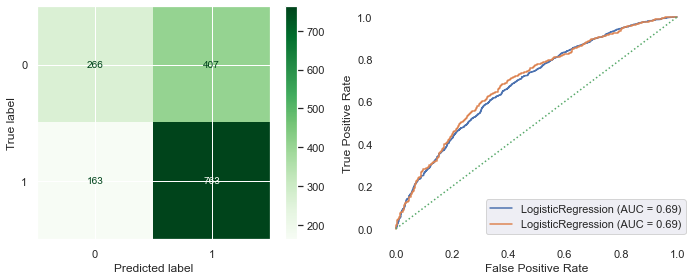

In [106]:
def evaluate_model(model, X_train, X_test, y_train, 
                   y_test, cmap='Greens', normalize=None,
                   classes=None,figsize=(10,4), graphs=False):
    
    """
    model :: classifier user desires to evaluate
    X_train :: X training data
    X_test :: X test data
    y_train :: y_train data
    y_test :: y_train data
    cmap :: color palette of confusion matrix
    normalize :: set to True if normalized confusion matrix is desired
    figsize :: desired plot size

    """
    
    # Print model accuracy
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')
    print('')
    
    # Option to show graphs
    if graphs == True:
        
        # Print classification report
        y_test_predict = model.predict(X_test)
        print(metrics.classification_report(y_test, y_test_predict,
                                            target_names=classes))

        # Plot confusion matrix
        fig,ax = plt.subplots(ncols=2,figsize=figsize)
        metrics.plot_confusion_matrix(model, X_test,y_test,cmap=cmap, 
                                      normalize=normalize,display_labels=classes,
                                      ax=ax[0])

        #Plot ROC curves
        
        with sns.axes_style("darkgrid"):
            curve = metrics.plot_roc_curve(model,X_train,y_train,ax=ax[1])
            curve2 = metrics.plot_roc_curve(model,X_test,y_test,ax=ax[1])
            curve.ax_.grid()
            curve.ax_.plot([0,1],[0,1],ls=':')
            fig.tight_layout()
            plt.show()

evaluate_model(model_log, X_train, X_test, y_train, 
                   y_test, graphs=True)

Now we'll build a function that accomplishes a few things:
- Conducts the full train / test split process
- Models the data
- Provides evaluation metrics
- Has options for choosing model type (e.g. logistic regression, random forest, SVM, XGBoost, etc.)
- Has an option for running a dummy model
- Has option for choosing a scaler if desired

Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.64879357 0.61930295 0.64209115 0.62147651 0.61744966]

Cross validation mean: 	62.98%
Training Accuracy: 64.35%
Test Accuracy: 64.35%

              precision    recall  f1-score   support

           0       0.62      0.40      0.48       673
           1       0.65      0.82      0.73       926

    accuracy                           0.64      1599
   macro avg       0.64      0.61      0.61      1599
weighted avg       0.64      0.64      0.62      1599



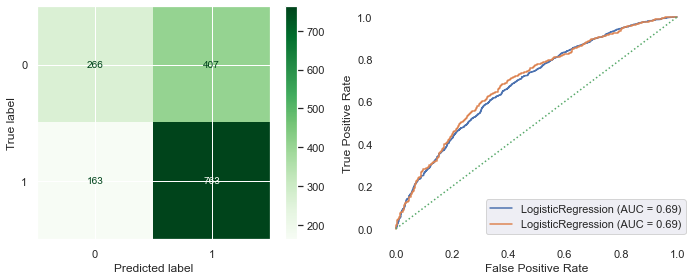

In [107]:
# Function to create models
def make_model(df, regressor=LogisticRegression, scale=False, graphs=False, dummy=False, cmap='Greens',
              slim=False, scaler=StandardScaler()):

    # Assigning X and y for train test split
    X = df.drop(['PlayerWin'], axis=1)
    y = df['PlayerWin']
    
    # Ensure target is integer format
    y=y.astype('int')

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=8)
    
    # Option to scale data with scaler type as parameter
    if scale==True:
        scaler = scaler
        X_train = pd.DataFrame(scaler.fit_transform(X_train))
        X_test = pd.DataFrame(scaler.transform(X_test))
    
    # Option to return dummy model
    if dummy == True:
        model_log = DummyClassifier(strategy='stratified')
        print('Using Dummy Model')
    else:
        model_log = regressor
    
    # Fit to X_train and y_train
    model_log.fit(X_train, y_train)
   
    # Print total number of samples
    total_samples = X_train.shape[0] + X_test.shape[0]
    print(f'Total number of samples: {total_samples}')
    print('------------------------------------------')
    
    # Option to suppress cross validation scores
    if slim == False:
        cross_val_check(str(regressor), model_log, X_train, y_train, X_test, y_test)
    
    evaluate_model(model_log, X_train, X_test, y_train, y_test, graphs=graphs, cmap=cmap)

make_model(model_df, scale=False, graphs=True, regressor=LogisticRegression())

## Logistic Regression

Now that we have a function to fully model our data, we can try our data on a few different types of models.  We'll start with basic logistic regression.

In [108]:
# Basic logistic regression
make_model(df, regressor=LogisticRegression(random_state=8), scale=False, graphs=False, cmap='Greens',
              slim=False)

Total number of samples: 5327
------------------------------------------
LogisticRegression(random_state=8) Cross Validation Scores:
[0.64879357 0.61930295 0.64209115 0.62147651 0.61744966]

Cross validation mean: 	62.98%
Training Accuracy: 64.35%
Test Accuracy: 64.35%



Let's see if using scalers makes a difference.  We'll try Power Transformer, Standard Scaler, and Robust Scaler.

In [109]:
print('Logistic Regression with PowerTransformer')
make_model(model_df, scale=True, graphs=False, regressor=LogisticRegression(), 
           scaler=PowerTransformer())
print('Logistic Regression with StandardScaler')
make_model(model_df, scale=True, graphs=False, regressor=LogisticRegression(), 
           scaler=StandardScaler())
print('Logistic Regression with RobustScaler')
make_model(model_df, scale=True, graphs=False, regressor=LogisticRegression(), 
           scaler=RobustScaler())

Logistic Regression with PowerTransformer
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.69705094 0.72654155 0.70911528 0.71006711 0.68993289]

Cross validation mean: 	70.65%
Training Accuracy: 75.46%
Test Accuracy: 70.29%

Logistic Regression with StandardScaler
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.6997319  0.72788204 0.68900804 0.70067114 0.68993289]

Cross validation mean: 	70.14%
Training Accuracy: 75.08%
Test Accuracy: 69.54%

Logistic Regression with RobustScaler
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.69436997 0.73458445 0.69705094 0.70201342 0.68993289]

Cross validation mean: 	70.36%
Training Accuracy: 75.24%
Test Accuracy: 69.48%



It looks like the power transformer is best for logistic regression, let's take a look at the full evaluation.

Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.69705094 0.72654155 0.70911528 0.71006711 0.68993289]

Cross validation mean: 	70.65%
Training Accuracy: 75.46%
Test Accuracy: 70.29%

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       673
           1       0.73      0.76      0.75       926

    accuracy                           0.70      1599
   macro avg       0.69      0.69      0.69      1599
weighted avg       0.70      0.70      0.70      1599



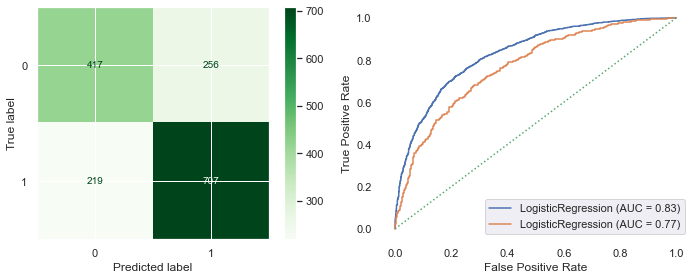

In [110]:
# Logistic regression with power transformer, full evalutation
make_model(model_df, scale=True, graphs=True, regressor=LogisticRegression(), scaler=PowerTransformer())

We were able to reach 70.29% test accuracy.  Let's run a dummy model to see if this score is better than a dummy model.

Using Dummy Model
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.49865952 0.48525469 0.52546917 0.53288591 0.50469799]

Cross validation mean: 	50.94%
Training Accuracy: 52.39%
Test Accuracy: 49.03%

              precision    recall  f1-score   support

           0       0.40      0.41      0.40       673
           1       0.56      0.55      0.56       926

    accuracy                           0.49      1599
   macro avg       0.48      0.48      0.48      1599
weighted avg       0.49      0.49      0.49      1599



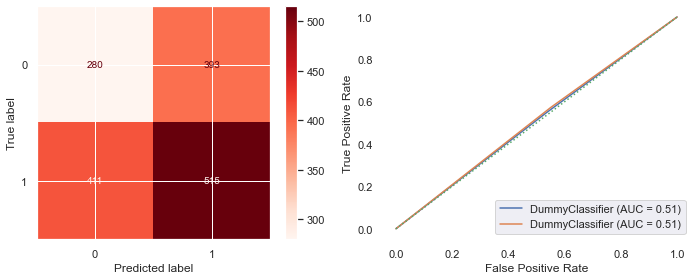

In [111]:
# Dummy model for comparison
make_model(model_df, scale=False, graphs=True, dummy=True, 
           cmap='Reds', regressor=LogisticRegression())

With a test accuracy of 51.72%, our logistic regression model with power transformer at 70.29% test accuracy is at least picking up on something.  Before diving into what it's using to make its predictions, let's try a few more models.

## Random Forest

Next we'll try random forest models to see how they perform, with and without scalers.

In [112]:
# Random forest not scaled
make_model(model_df, scale=False, graphs=False, regressor=RandomForestClassifier())

Total number of samples: 5327
------------------------------------------
RandomForestClassifier() Cross Validation Scores:
[0.72922252 0.73190349 0.74128686 0.72885906 0.67248322]

Cross validation mean: 	72.08%
Training Accuracy: 100.00%
Test Accuracy: 70.61%



In [113]:
# Random forest with different scales
print('Random Forest with PowerTransformer')
make_model(model_df, scale=True, graphs=False, 
           regressor=RandomForestClassifier(random_state=8), scaler=PowerTransformer())
print('Random Forest with StandardScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=RandomForestClassifier(random_state=8), scaler=StandardScaler())
print('Random Forest with RobustScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=RandomForestClassifier(random_state=8), scaler=RobustScaler())


Random Forest with PowerTransformer
Total number of samples: 5327
------------------------------------------
RandomForestClassifier(random_state=8) Cross Validation Scores:
[0.73592493 0.72117962 0.71983914 0.72751678 0.68322148]

Cross validation mean: 	71.75%
Training Accuracy: 100.00%
Test Accuracy: 71.61%

Random Forest with StandardScaler
Total number of samples: 5327
------------------------------------------
RandomForestClassifier(random_state=8) Cross Validation Scores:
[0.73324397 0.72117962 0.72252011 0.72483221 0.68456376]

Cross validation mean: 	71.73%
Training Accuracy: 100.00%
Test Accuracy: 71.48%

Random Forest with RobustScaler
Total number of samples: 5327
------------------------------------------
RandomForestClassifier(random_state=8) Cross Validation Scores:
[0.73324397 0.72117962 0.72252011 0.72751678 0.68456376]

Cross validation mean: 	71.78%
Training Accuracy: 100.00%
Test Accuracy: 71.54%



We were almost able to crack 72% with the power tranformer.  Let's take a look at the full evaluation.

Total number of samples: 5327
------------------------------------------
RandomForestClassifier(random_state=8) Cross Validation Scores:
[0.73592493 0.72117962 0.71983914 0.72751678 0.68322148]

Cross validation mean: 	71.75%
Training Accuracy: 100.00%
Test Accuracy: 71.61%

              precision    recall  f1-score   support

           0       0.69      0.60      0.64       673
           1       0.73      0.80      0.77       926

    accuracy                           0.72      1599
   macro avg       0.71      0.70      0.70      1599
weighted avg       0.71      0.72      0.71      1599



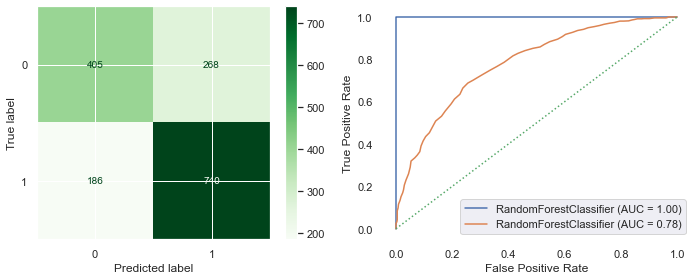

In [114]:
make_model(model_df, scale=True, graphs=True, 
           regressor=RandomForestClassifier(random_state=8), scaler=PowerTransformer())

Random forest model with the power transformer is our best model so far at 71.61% test accuracy.

## Support Vector Machines

Next we'll take a look at support vector machines.

In [115]:
# SVM without scaling
make_model(model_df, scale=False, graphs=False, regressor=svm.SVC())

Total number of samples: 5327
------------------------------------------
SVC() Cross Validation Scores:
[0.62466488 0.61260054 0.60455764 0.59060403 0.60402685]

Cross validation mean: 	60.73%
Training Accuracy: 61.16%
Test Accuracy: 62.48%



In [116]:
# Support Vector Machines with different scalers
print('Support Vector Machine with PowerTransformer')
make_model(model_df, scale=True, graphs=False, 
           regressor=svm.SVC(), scaler=PowerTransformer())
print('Support Vector Machine with StandardScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=svm.SVC(), scaler=StandardScaler())
print('Support Vector Machine with RobustScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=svm.SVC(), scaler=RobustScaler())

Support Vector Machine with PowerTransformer
Total number of samples: 5327
------------------------------------------
SVC() Cross Validation Scores:
[0.74530831 0.73592493 0.73324397 0.73422819 0.69798658]

Cross validation mean: 	72.93%
Training Accuracy: 87.53%
Test Accuracy: 71.48%

Support Vector Machine with StandardScaler
Total number of samples: 5327
------------------------------------------
SVC() Cross Validation Scores:
[0.72922252 0.71983914 0.7077748  0.71946309 0.67785235]

Cross validation mean: 	71.08%
Training Accuracy: 86.88%
Test Accuracy: 70.17%

Support Vector Machine with RobustScaler
Total number of samples: 5327
------------------------------------------
SVC() Cross Validation Scores:
[0.71849866 0.71983914 0.70375335 0.72348993 0.68590604]

Cross validation mean: 	71.03%
Training Accuracy: 81.87%
Test Accuracy: 71.17%



We came pretty close to 72% with SVM using the power transformer, but random forest is still our best model.  Let's take a look at SVM using power transformer, which scored 71.48% test accuracy.

Total number of samples: 5327
------------------------------------------
SVC() Cross Validation Scores:
[0.74530831 0.73592493 0.73324397 0.73422819 0.69798658]

Cross validation mean: 	72.93%
Training Accuracy: 87.53%
Test Accuracy: 71.48%

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       673
           1       0.75      0.77      0.76       926

    accuracy                           0.71      1599
   macro avg       0.71      0.70      0.71      1599
weighted avg       0.71      0.71      0.71      1599



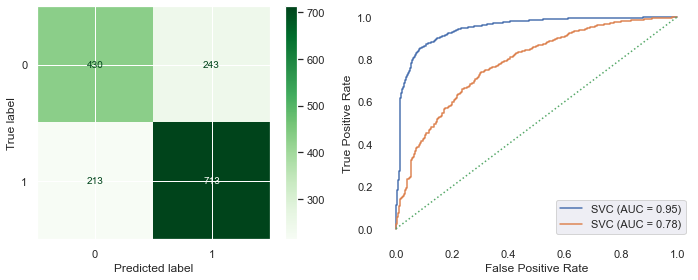

In [117]:
make_model(model_df, scale=True, graphs=True, 
           regressor=svm.SVC(), scaler=PowerTransformer())

## XGBoost

Finally, let's take a look at XGBoost.

In [118]:
# XGBoost with no scaler
make_model(model_df, scale=False, graphs=False, regressor=XGBClassifier())

Total number of samples: 5327
------------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) Cross Validation Scores:
[0.71313673 0.72117962 0.72788204 0.72214765 0.69127517]

Cross validation mean: 	71.51%
Training Accuracy: 100.00%
Test Accuracy: 70.36%



In [119]:
# XGBoost with different scalers
print('XGBoost with PowerTransformer')
make_model(model_df, scale=True, graphs=False, 
           regressor=XGBClassifier(random_state=8), scaler=PowerTransformer())
print('XGBoost with StandardScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=XGBClassifier(random_state=8), scaler=StandardScaler())
print('XGBoost with RobustScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=XGBClassifier(random_state=8), scaler=RobustScaler())

XGBoost with PowerTransformer
Total number of samples: 5327
------------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) Cross Validation Scores:
[0.71313673 0.72117962 0.72788204 0.72214765 0.69127517]

Cross validation mean: 	71.51%
Training Accuracy: 100.00%
Test Accuracy: 70.36%

XGBoost with StandardScaler
Total number of samples: 5327
------------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', co

While worth a shot, XGBoost did not outperform our SVM model.  While most models look nearly identical in terms of accuracy, let's take a closer look at XGBoost with robust scaler, since it has the highest cross validation mean at 71.54%.

In [120]:
make_model(model_df, scale=True, graphs=False, 
           regressor=XGBClassifier(), scaler=RobustScaler())

Total number of samples: 5327
------------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) Cross Validation Scores:
[0.71447721 0.72117962 0.72788204 0.72214765 0.69127517]

Cross validation mean: 	71.54%
Training Accuracy: 100.00%
Test Accuracy: 70.36%



# Feature Analysis

Let's take a look at how logistic regression values different features in our full model dataset.  We'll create a model accuracy function and a plot coefficients function to explore the importances.

Before that, we'll redo our train test split using the power tranformer, which was best for linear regression.

In [121]:
# Make model_df from a copy of our dataframe up to this point
model_df = df.copy()

# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Define and scale X train and test
scaler = PowerTransformer()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

# Create and fit logistic regressoin
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

# Print shape
print(X_train.shape)
print(X_test.shape)

(3728, 232)
(1599, 232)


Now we'll create our functions and take a look a the feature importances.

Training Accuracy: 75.46%
Test Accuracy: 70.29%


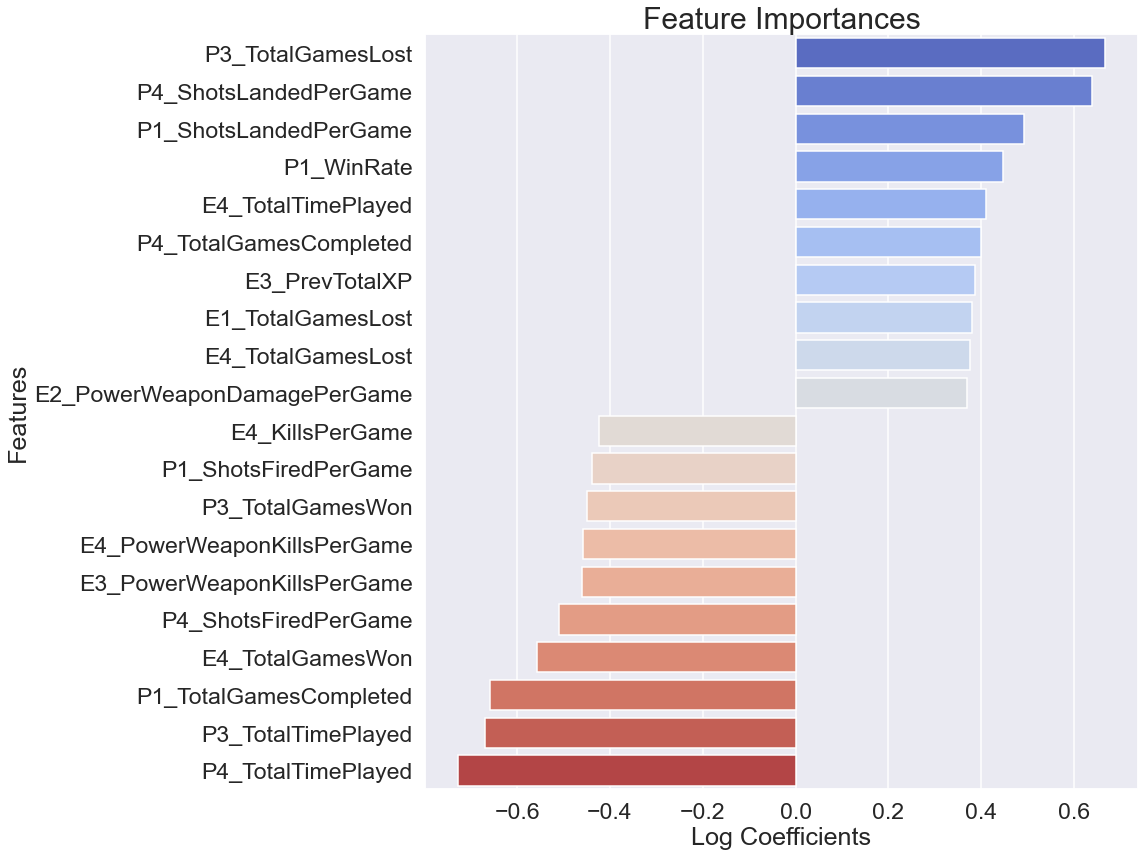

In [122]:
# Function to show model accuracy
def model_accuracy(model, X_train, y_train, X_test, y_test):
    
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')

# Uncomment line below to create images for presentation
# sns.set_context('talk')

# Function to plot logistic regression coefficients
def plot_coefficients(model, features, X_train, X_test, y_train, y_test, count=20):    
    
    # Create a list of coefficients
    coeffs = pd.Series(model.coef_.flatten(), index=features.columns).sort_values(ascending=False)
#     coeffs = coeffs[:20]
    top_coeffs = coeffs[:count]
    bottom_coeffs = coeffs[-count:]
    coeffs = top_coeffs.append(bottom_coeffs)
    
    # Display accuracy of newly trained model
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

    # Create coefficients plot
    with sns.plotting_context("talk", font_scale=1.4):
        with sns.axes_style("darkgrid"):
            plt.figure(figsize=(16, 12))
            ax = sns.barplot(x=coeffs, y=coeffs.index, palette='coolwarm')
            ax.set(xlabel='Log Coefficients', ylabel='Features')
            ax.set_title("Feature Importances",fontsize=30)
    
    # Save image
    plt.tight_layout()

    
plot_coefficients(model_log, features, X_train, X_test, y_train, y_test, count=10)

It's a bit difficult to interpret the model importances with so many features.  Let's try condesning the features by average feature per team and see if that returns more interpretable importances.

# Model with Condensed Features

We'll create a function to condense the features on each team.

In [123]:
# Function to convert model dataframe from individual players stats to averaged team stats
def condense_features(df, feature_list):
    
    # Empty dataframe
    df_total=pd.DataFrame()
    
    # Copy PlayerWin column
    df_total['PlayerWin'] = df['PlayerWin']
    
    # Loop through features for each player
    for feature in feature_list:
        
        # Add sum features for respective teams
        df_total[f'Player_{feature}'] = df[f'P1_{feature}'] + df[f'P2_{feature}'] + df[f'P3_{feature}'] + df[f'P4_{feature}']
        df_total[f'Enemy_{feature}'] = df[f'E1_{feature}'] + df[f'E2_{feature}'] + df[f'E3_{feature}'] + df[f'E4_{feature}']
        
        # Divide by 4 to get average
        df_total[f'Player_{feature}'] = df_total[f'Player_{feature}'] / 4
        df_total[f'Enemy_{feature}'] = df_total[f'Enemy_{feature}'] / 4

    return df_total
    
df = condense_features(df, feature_list)
df.head(5)

,PlayerWin,Player_WinRate,Enemy_WinRate,Player_K/D,Enemy_K/D,Player_Accuracy,Enemy_Accuracy,Player_TotalGamesCompleted,Enemy_TotalGamesCompleted,Player_TotalGamesWon,Enemy_TotalGamesWon,Player_TotalGamesLost,Enemy_TotalGamesLost,Player_PrevTotalXP,Enemy_PrevTotalXP,Player_SpartanRank,Enemy_SpartanRank,Player_TotalTimePlayed,Enemy_TotalTimePlayed,Player_KillsPerGame,Enemy_KillsPerGame,Player_HeadshotsPerGame,Enemy_HeadshotsPerGame,Player_WeaponDamagePerGame,Enemy_WeaponDamagePerGame,Player_ShotsFiredPerGame,Enemy_ShotsFiredPerGame,Player_ShotsLandedPerGame,Enemy_ShotsLandedPerGame,Player_MeleeKillsPerGame,Enemy_MeleeKillsPerGame,Player_MeleeDamagePerGame,Enemy_MeleeDamagePerGame,Player_AssassinationsPerGame,Enemy_AssassinationsPerGame,Player_GroundPoundKillsPerGame,Enemy_GroundPoundKillsPerGame,Player_GroundPoundDamagePerGame,Enemy_GroundPoundDamagePerGame,Player_ShoulderBashKillsPerGame,Enemy_ShoulderBashKillsPerGame,Player_ShoulderBashDamagePerGame,Enemy_ShoulderBashDamagePerGame,Player_GrenadeDamagePerGame,Enemy_GrenadeDamagePerGame,Player_PowerWeaponKillsPerGame,Enemy_PowerWeaponKillsPerGame,Player_PowerWeaponDamagePerGame,Enemy_PowerWeaponDamagePerGame,Player_PowerWeaponGrabsPerGame,Enemy_PowerWeaponGrabsPerGame,Player_PowerWeaponPossessionTimePerGame,Enemy_PowerWeaponPossessionTimePerGame,Player_DeathsPerGame,Enemy_DeathsPerGame,Player_AssistsPerGame,Enemy_AssistsPerGame,Player_GrenadeKillsPerGame,Enemy_GrenadeKillsPerGame
0,1,1.210757,0.669667,1.012847,1.052453,0.343911,0.377892,1547.50,791.25,804.75,296.50,575.50,427.00,11323792.25,19864156.50,122.75,129.00,155.392598,90.771716,14.352159,12.528017,1.852401,3.245726,1833.022633,1614.832810,350.769993,284.836536,122.093743,107.301383,0.450532,0.784631,53.410141,104.684133,0.087720,0.183599,0.037535,0.011398,6.223727,1.390453,0.046052,0.030406,8.493218,4.571941,152.907140,69.141174,11.375006,7.370881,1456.458951,957.861714,0.007328,0.210221,0.059127,0.040126,14.175924,11.903975,5.750571,5.431987,0.629894,0.339380
1,1,1.092604,0.844752,0.966017,1.032910,0.361132,0.348593,2102.75,1126.50,985.00,440.75,883.75,549.25,15760299.00,20310125.75,123.25,122.75,228.236587,127.340630,15.082458,13.304141,2.466798,2.366894,2004.200193,1758.109480,366.133941,331.543259,132.333355,114.094355,0.443109,0.446236,51.917505,53.357637,0.071125,0.097556,0.013710,0.012978,2.553156,3.087830,0.049922,0.041756,9.799551,8.424797,154.171574,108.329935,12.076364,10.119559,1567.896852,1319.213762,0.029795,0.088160,0.057175,0.056816,15.822224,12.966153,6.757510,5.487340,0.563756,0.452225
2,1,1.236401,1.498865,1.165205,1.004284,0.350705,0.366385,4053.00,1043.50,1926.50,470.50,1606.50,452.75,29123969.50,23281604.75,149.75,149.00,433.955225,117.960500,17.090165,14.359567,2.992595,2.390085,2236.044462,1845.817531,419.151117,299.243666,146.988742,109.579021,0.369026,0.418560,44.049533,56.723750,0.059120,0.096795,0.006917,0.020703,1.267258,4.503209,0.021851,0.075789,4.565818,14.093139,122.598942,131.595838,14.356398,11.019788,1834.748495,1398.571346,0.009134,0.069779,0.057599,0.054151,14.847632,14.689255,6.497260,5.472017,0.437905,0.553559
3,1,1.678911,1.084483,0.975596,1.351607,0.363884,0.345664,1156.25,2790.75,614.25,1309.00,437.00,1131.25,21807131.75,20057565.50,148.25,148.75,115.280680,305.389289,15.404560,16.868286,2.497441,3.465595,2017.211773,2215.650307,362.514786,407.095833,131.483937,140.936262,0.413799,0.338067,56.002394,42.331793,0.094099,0.060459,0.013204,0.011155,2.843651,2.080700,0.064926,0.018183,11.934804,4.778267,117.690136,111.300174,12.318836,13.578605,1586.016652,1752.360213,0.024470,0.029650,0.051699,0.059983,15.956663,13.165654,6.234410,6.490371,0.474492,0.464946
4,1,1.618018,3.206811,1.049059,1.136995,0.351835,0.330285,3645.75,1986.00,1978.00,1409.25,1277.00,410.00,21263940.00,55913466.50,149.00,148.75,370.002917,219.953054,15.841367,14.602590,2.727513,2.290620,2079.125135,1869.191549,410.707094,363.659703,144.332457,119.042991,0.399702,0.612712,44.829888,79.336461,0.065529,0.189418,0.0

In [124]:
# df.to_csv('data/Model_W_Condensed_Features_HuskyRaid.csv')

In [125]:
df = pd.read_csv('data/Model_W_Condensed_Features_HuskyRaid.csv')
df = df.drop(['Unnamed: 0'], axis=1)

Next we'll apply our train test split again.  Before checking out the features, let's see if condensing the features has any affect on model performances.

In [126]:
# Make model_df from a copy of our dataframe up to this point
model_df = df.copy()

# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Print shape
print(X_train.shape)
print(X_test.shape)

(3728, 58)
(1599, 58)


## Logistic Regression, Random Forest, SVM, XGBoost

We'll rerun each model we tested before, but now with our condensed feature set.

In [127]:
print('Logistic Regression with PowerTransformer')
make_model(model_df, scale=True, graphs=False, regressor=LogisticRegression(), scaler=PowerTransformer())
print('Logistic Regression with StandardScaler')
make_model(model_df, scale=True, graphs=False, regressor=LogisticRegression(), scaler=StandardScaler())
print('Logistic Regression with RobustScaler')
make_model(model_df, scale=True, graphs=False, regressor=LogisticRegression(), scaler=RobustScaler())

# Random forest with power transformer scale
print('Random Forest with PowerTransformer')
make_model(model_df, scale=True, graphs=False, 
           regressor=RandomForestClassifier(random_state=8), scaler=PowerTransformer())
print('Random Forest with StandardScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=RandomForestClassifier(random_state=8), scaler=StandardScaler())
print('Random Forest with RobustScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=RandomForestClassifier(random_state=8), scaler=RobustScaler())

# Support Vector Machines with different scalers
print('Support Vector Machine with PowerTransformer')
make_model(model_df, scale=True, graphs=False, 
           regressor=svm.SVC(), scaler=PowerTransformer())
print('Support Vector Machine with StandardScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=svm.SVC(), scaler=StandardScaler())
print('Support Vector Machine with RobustScaler')
make_model(model_df, scale=True, graphs=False, 
           regressor=svm.SVC(), scaler=RobustScaler())

Logistic Regression with PowerTransformer
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.72922252 0.74128686 0.72654155 0.72483221 0.69261745]

Cross validation mean: 	72.29%
Training Accuracy: 73.07%
Test Accuracy: 72.73%

Logistic Regression with StandardScaler
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.71447721 0.72654155 0.730563   0.71275168 0.66577181]

Cross validation mean: 	71.00%
Training Accuracy: 72.37%
Test Accuracy: 71.73%

Logistic Regression with RobustScaler
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.71447721 0.72788204 0.72654155 0.7114094  0.66577181]

Cross validation mean: 	70.92%
Training Accuracy: 72.42%
Test Accuracy: 71.61%

Random Forest with PowerTransformer
Total number of samples: 5327
------------------------------------------


Looks like we beat our highest score with the condensed feature set!  Let's take a look at logistic regression with the power transformer in more detail.

Logistic Regression with PowerTransformer
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.72922252 0.74128686 0.72654155 0.72483221 0.69261745]

Cross validation mean: 	72.29%
Training Accuracy: 73.07%
Test Accuracy: 72.73%

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       673
           1       0.75      0.79      0.77       926

    accuracy                           0.73      1599
   macro avg       0.72      0.72      0.72      1599
weighted avg       0.73      0.73      0.73      1599



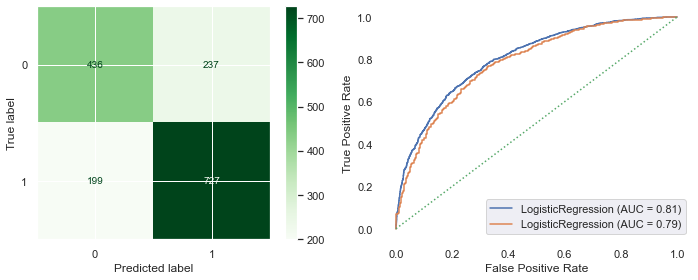

In [128]:
print('Logistic Regression with PowerTransformer')
make_model(model_df, scale=True, graphs=True, regressor=LogisticRegression(), scaler=PowerTransformer())

## Condensed Feature Analysis

Let's take a look at the feature importances now that we have condensed the featuers.  We'll perform our train / test split again using the power transformer, and then we'll run our feature importances function.

In [129]:
# Make model_df from a copy of our dataframe up to this point
model_df = df.copy()

# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Define and scale X train and test
scaler = PowerTransformer()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

# Create and fit logistic regressoin
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

# Print shape
print(X_train.shape)
print(X_test.shape)

(3728, 58)
(1599, 58)


Training Accuracy: 73.07%
Test Accuracy: 72.73%


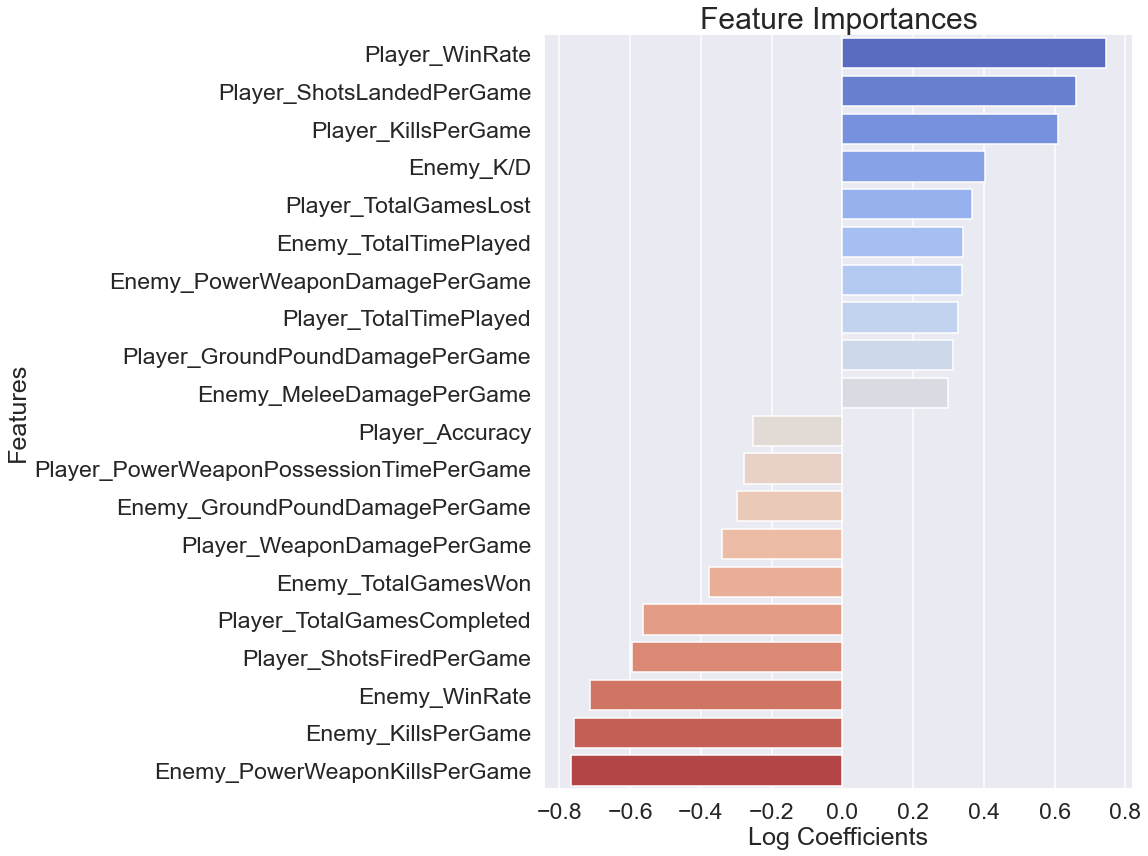

In [130]:
plot_coefficients(model_log, features, X_train, X_test, y_train, y_test, count=10)

With the slimmed down features, we see that Player Winrate is now the most important feature as well as player shots landed per game.  It's still a bit difficult to understand why something like ShotsLandedPerGame is ranked so high, but perhaps this speaks to accuracy being an important factor.  

# Model Removing Multicollinearity

We'll take one last step regarding model interpretation by removing multicollinearity.  

In [68]:
df = pd.read_csv('data/Model_W_Condensed_Features_HuskyRaid.csv')
df = df.drop(['Unnamed: 0'], axis=1)
model_df = df.copy()

columns = ['PlayerWin', 'Player_WinRate', 'Enemy_WinRate', 'Player_K/D',
       'Enemy_K/D', 'Player_Accuracy', 'Enemy_Accuracy',
       'Player_TotalGamesCompleted', 'Enemy_TotalGamesCompleted',
       'Player_SpartanRank', 'Enemy_SpartanRank',
       'Player_KillsPerGame', 'Enemy_KillsPerGame',
       'Player_HeadshotsPerGame', 'Enemy_HeadshotsPerGame',
       'Player_DeathsPerGame','Enemy_DeathsPerGame', 
       'Player_GrenadeKillsPerGame', 'Enemy_GrenadeKillsPerGame']

model_df = model_df[columns]

model_df.columns

Index(['PlayerWin', 'Player_WinRate', 'Enemy_WinRate', 'Player_K/D',
       'Enemy_K/D', 'Player_Accuracy', 'Enemy_Accuracy',
       'Player_TotalGamesCompleted', 'Enemy_TotalGamesCompleted',
       'Player_SpartanRank', 'Enemy_SpartanRank', 'Player_KillsPerGame',
       'Enemy_KillsPerGame', 'Player_HeadshotsPerGame',
       'Enemy_HeadshotsPerGame', 'Player_DeathsPerGame', 'Enemy_DeathsPerGame',
       'Player_GrenadeKillsPerGame', 'Enemy_GrenadeKillsPerGame'],
      dtype='object')

(<Figure size 2160x2160 with 2 Axes>, <AxesSubplot:>)

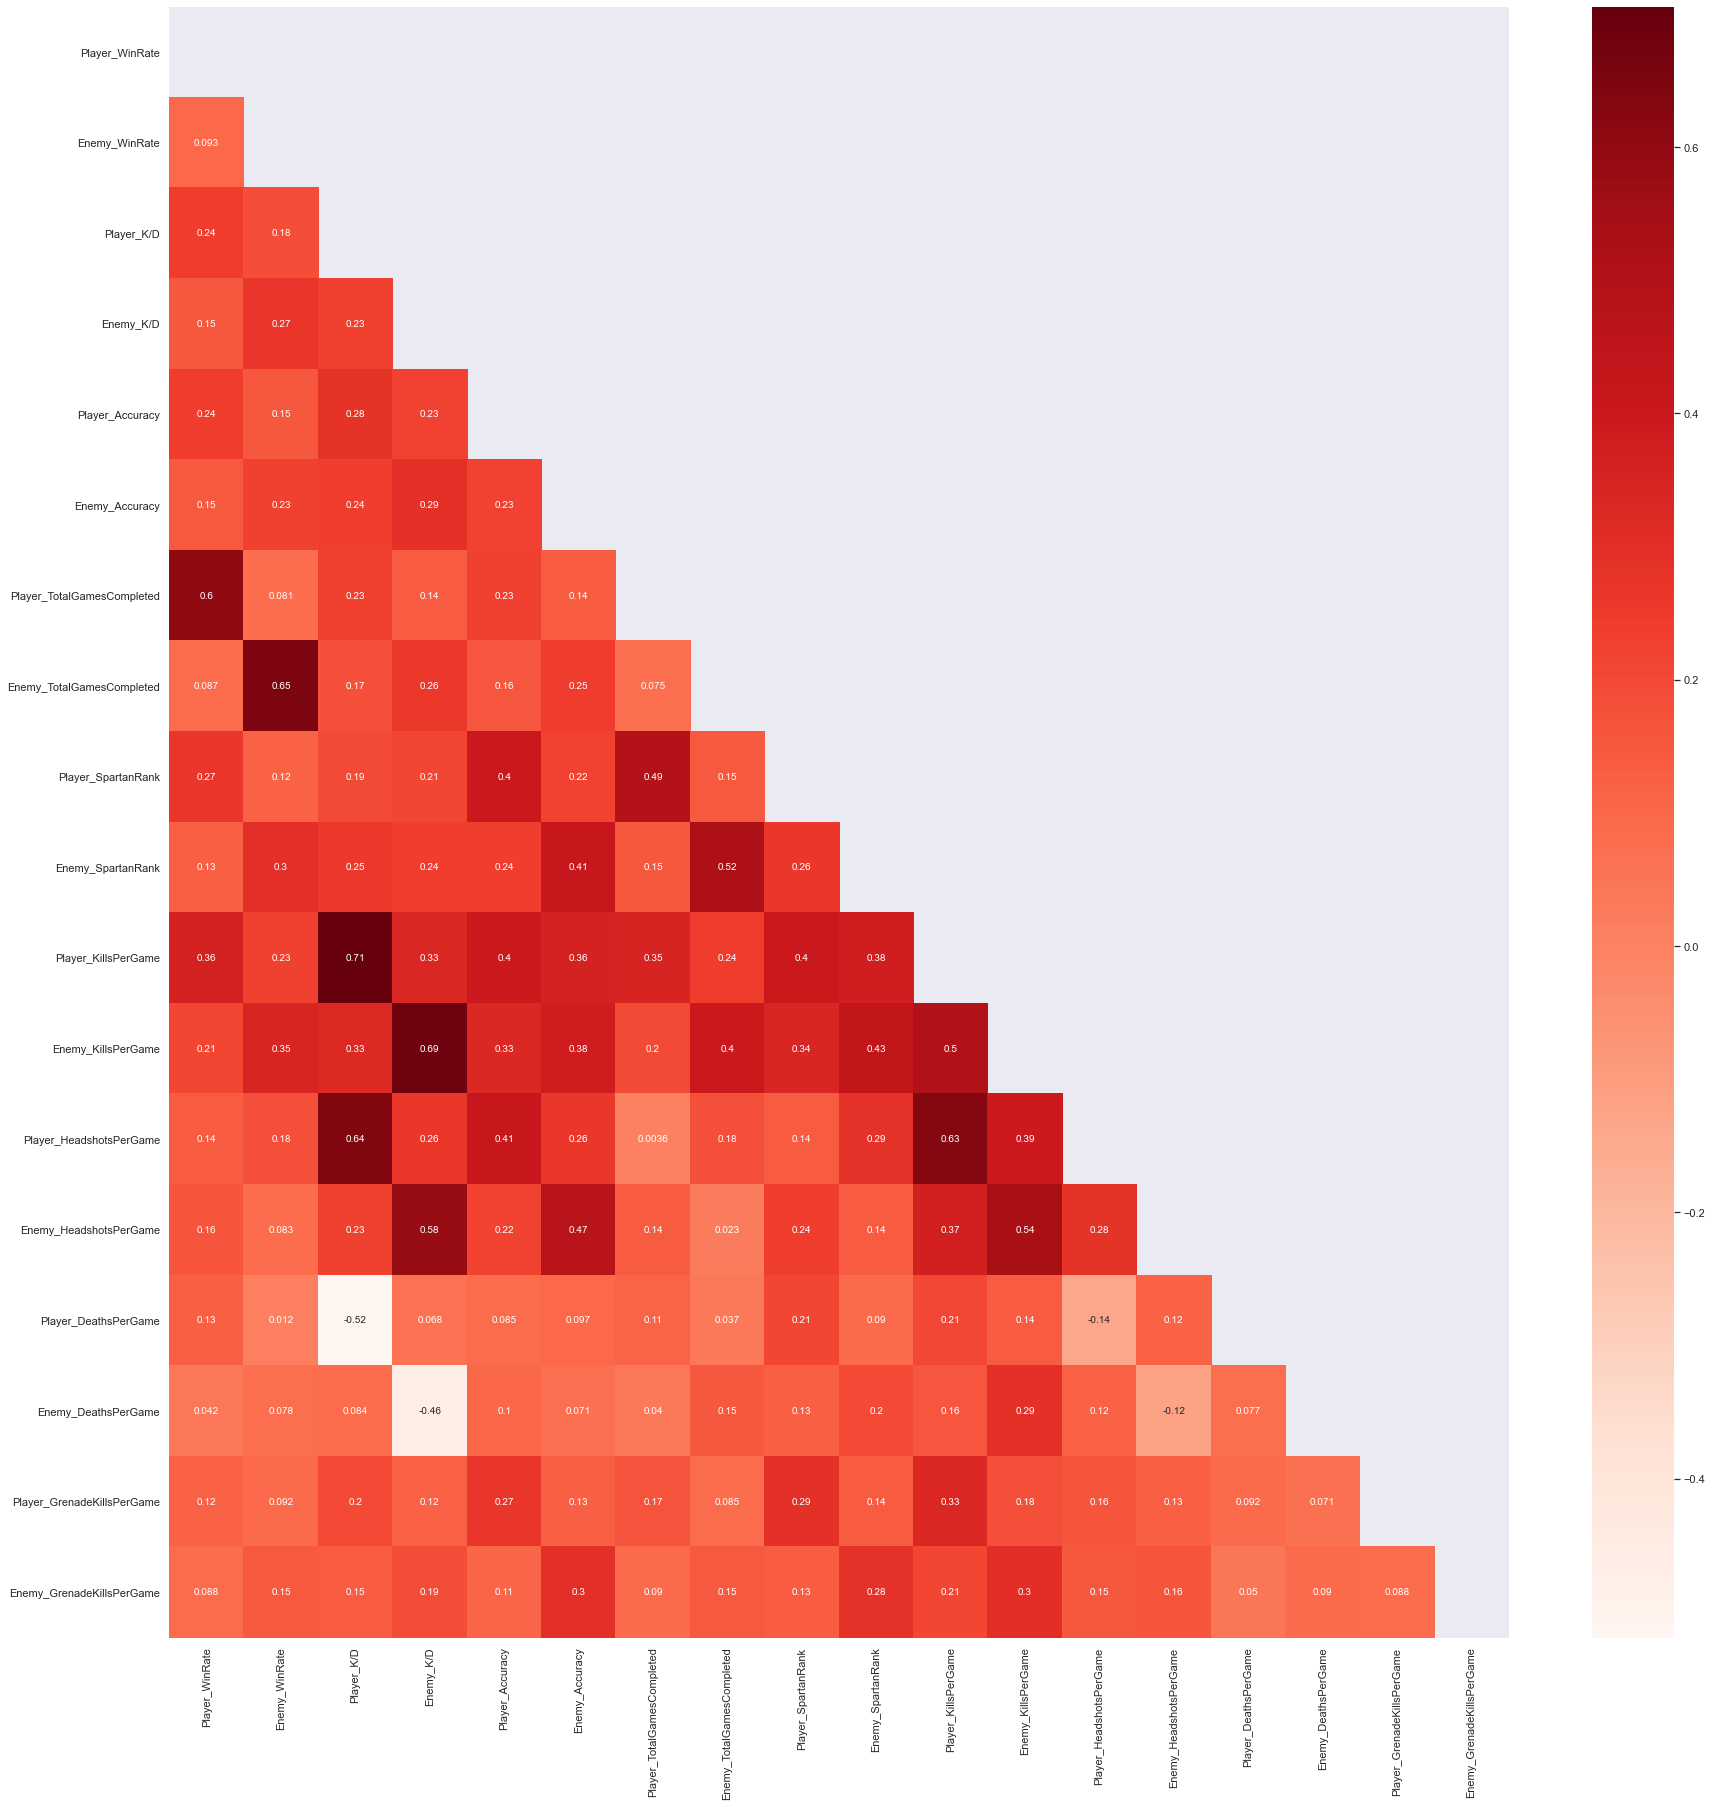

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Create function to output multicollinearity heatmap
def heatmap(df_name, figsize=(30,30), cmap='Reds'):
    with sns.axes_style("darkgrid"):
        corr = df_name.drop('PlayerWin',axis=1).corr()
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, annot=True, cmap=cmap, mask=mask)
    
    return fig, ax

heatmap(model_df)

It looks like we were able to get rid of multicollinear features that broached the 0.75 threshold.  Let's run the train test split again and check out the feature importances.

In [58]:
# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Define and scale X train and test
scaler = PowerTransformer()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

# Create and fit logistic regressoin
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

# Print shape
print(X_train.shape)
print(X_test.shape)

(3728, 18)
(1599, 18)


Training Accuracy: 72.40%
Test Accuracy: 71.29%


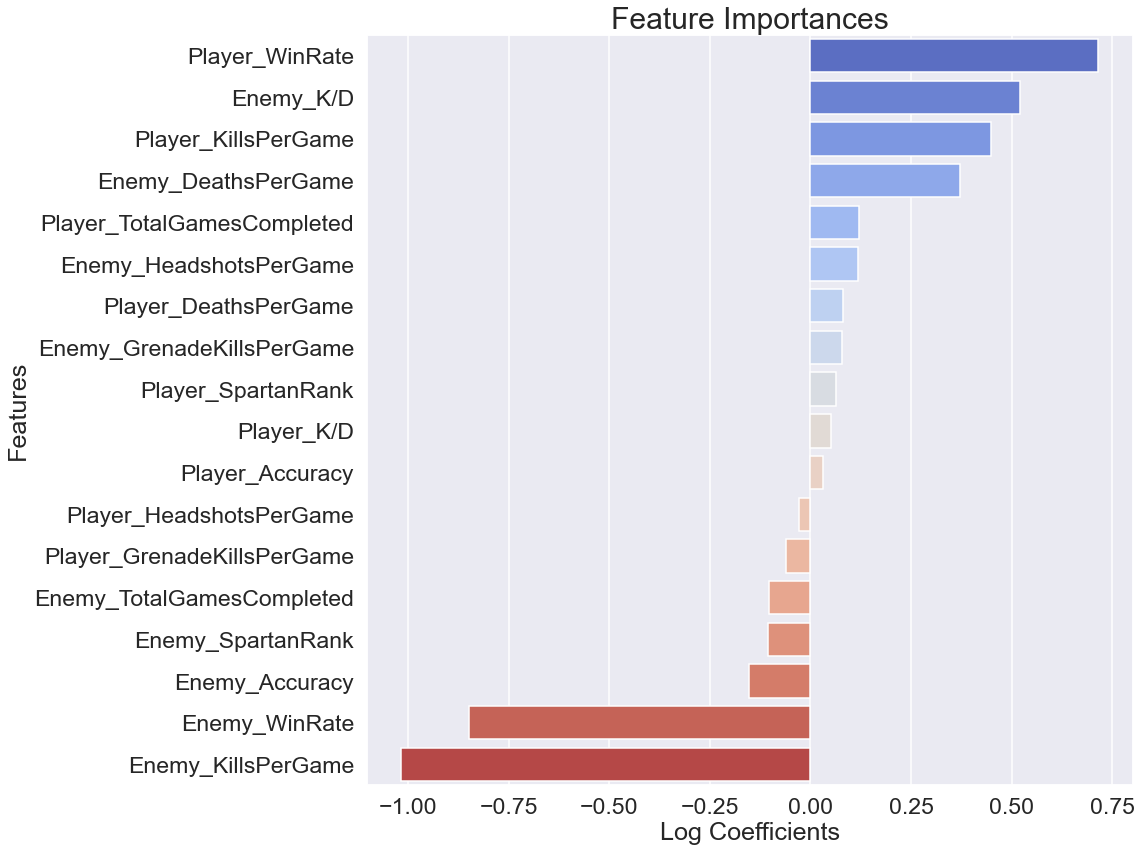

In [59]:
plot_coefficients(model_log, features, X_train, X_test, y_train, y_test, count=10)

It seems that Player_WinRate is still the most important feature in predicting the outcome of a match.

# Best Model

We explored many model types with a variety of scalers and datasets.  The best model for predicting victory using only gamertags and data available from the API was the per-game statistics condensed by player and enemy teams using logistic regression and the power transformer for scaling.

(3728, 58)
(1599, 58)
Logistic Regression with PowerTransformer
Total number of samples: 5327
------------------------------------------
LogisticRegression() Cross Validation Scores:
[0.72922252 0.74128686 0.72654155 0.72483221 0.69261745]

Cross validation mean: 	72.29%
Training Accuracy: 73.07%
Test Accuracy: 72.73%

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       673
           1       0.75      0.79      0.77       926

    accuracy                           0.73      1599
   macro avg       0.72      0.72      0.72      1599
weighted avg       0.73      0.73      0.73      1599



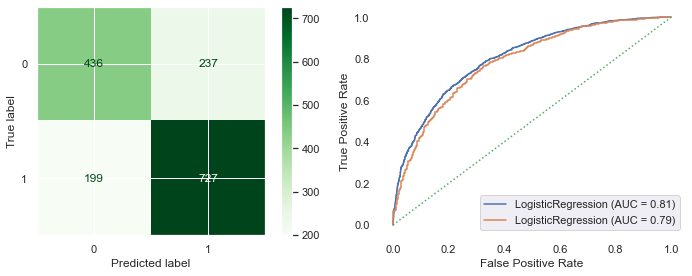

In [60]:
df = pd.read_csv('data/Model_W_Condensed_Features_HuskyRaid.csv')
df = df.drop(['Unnamed: 0'], axis=1)

# Make model_df from a copy of our dataframe up to this point
model_df = df.copy()

# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Print shape
print(X_train.shape)
print(X_test.shape)

print('Logistic Regression with PowerTransformer')
make_model(model_df, scale=True, graphs=True, regressor=LogisticRegression(), scaler=PowerTransformer())

The model is more precise at predicting victory over defeat, and this might be due to the fact that the matches compiled for the dataframe came from players that were fairly experienced in the Super Fiesta Party playlist.  In the future, it might be worth exploring matches from competitors with less play time and less experience in the playlist.

# Conclusions and Recommendations

For this specific playlist and with players who were most likely more skilled than average, we were able to predict the victor of a match with 72.73% accuracy using only information gathered by the API and no details about what actually occurred during the match.  

While I admittedly have no knowledge on best practices in ensuring a positive player experience, I believe an ideal matchmaking algorithm should not be predictable above a certain threshold, ideally not much higher than 50%.

It is entirely possible that matchmaking algorithms are already optimized to meet this ideal standard.  Perhaps sourcing modeling data from more skilled players in a very specific playlist would naturally lead to a higher than desired predictive quality simply because there are not enough equally skilled players entering matchmaking to ensure an even match at various hours of the day.

However, if that's not the case, a solution to uneven matchmaking might come in the form of a machine learning model as simple and efficient as logistic regression using readily available player data.  If something like this isn't being used, it could be implemented experimentally.

I should note that none of the modeling was conducted with ranked matchmaking, which certainly exists in Halo 5 and many other competitive games.  That system is likely more nuanced and robust, and deserves its own round of modeling and analysis.

# Next Steps

Regarding the Super Fiesta Party playlist, where players spawn with random weapons throughout the match, there exists a 'Match Events' API call that details nearly every action that happened in any given match.  Most importantly, this provides information on what weapons players spawned with throughout the match.  Given the fact that the weapons are randomized, frequenters of Super Fiesta Party will (or should) freely admit that luck with the random weapons varies substantially.

This project was originally concieved with this in mind, and the goal was to predict victory based on random weapon spawns alone.  The hurdle we encountered was that there was not a way to decode the +100 weapon variants.  343 Industries admitted in a forum post that adding this to the API would not be trivial, and given the API is technically a beta, they're under no obligation to give us this information.  However, it should be possible to decode the weapon variants through some individual data collection conducted through custom matches.

Finally, we would like to exapnd our modeling dataset to a variety of skill levels and playlists, which will be possible by identifying players that meet this criteria.  It would certainly be worthwhile to determine whether or not ranked matchmaking has the same level of predictive quality.